In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import *
from keras.optimizers import Adam
import os

Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
df = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)

In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,15.27,15.49,15.27,15.48,11.977631,18937700
2015-05-18,15.47,15.64,15.45,15.58,12.055005,19491900
2015-05-19,15.59,15.63,15.45,15.50,11.993106,15145300
2015-05-20,15.54,15.56,15.26,15.30,11.838357,22391500
2015-05-21,15.28,15.55,15.26,15.51,12.000844,23962000
...,...,...,...,...,...,...
2020-05-08,4.96,5.25,4.95,5.24,5.240000,101333800
2020-05-11,5.18,5.19,5.05,5.12,5.120000,75593900
2020-05-12,5.15,5.22,4.97,4.98,4.980000,70965200


In [9]:
forecast_col = 'High'

In [10]:
df1 = df[[forecast_col]]
df1

,High
Date,
2015-05-15,15.49
2015-05-18,15.64
2015-05-19,15.63
2015-05-20,15.56
2015-05-21,15.55
...,...
2020-05-08,5.25
2020-05-11,5.19
2020-05-12,5.22


In [34]:
scaler = MinMaxScaler()

data1 = scaler.fit_transform(df[forecast_col].values.reshape(df[forecast_col].shape[0], 1))
data2 = scaler.fit_transform(df['Open'].values.reshape(df['Open'].shape[0], 1))
#data3 = scaler.fit_transform(df['Open'].values.reshape(df['Open'].shape[0], 1))

numpy.ndarray

In [33]:
 result = pd.concat([data1, data2], axis=1, join='inner')

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [16]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
look_back = 14
# forecast_out = 1
X,y = processData(data,look_back)

In [17]:

train_pct = 0.80

X_train,X_test = X[:int(X.shape[0]*train_pct)],X[int(X.shape[0]*train_pct):]
y_train,y_test = y[:int(y.shape[0]*train_pct)],y[int(y.shape[0]*train_pct):]

#Reshape data into (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(995, 14, 1)
(249, 14, 1)
(995,)
(249,)


In [20]:
adam = Adam(lr=0.003)

file_path = 'daily_lstm_model_weights.h5'

callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)

callbacks = [early_stopping, callback_checkpoint, reduce_lr]

model = Sequential()

model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

model.add(LSTM(16))

model.add(Dense(1))

model.compile(loss='mse', optimizer=adam)

In [21]:

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks, shuffle=True)

Train on 995 samples, validate on 249 samples
Epoch 1/100
995/995 [==============================] - 1s 907us/step - loss: 0.0509 - val_loss: 0.0284
Epoch 2/100
995/995 [==============================] - 0s 262us/step - loss: 0.0043 - val_loss: 0.0050
Epoch 3/100
995/995 [==============================] - 0s 268us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/100
995/995 [==============================] - 0s 254us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
995/995 [==============================] - 0s 251us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
995/995 [==============================] - 0s 250us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/100
995/995 [==============================] - 0s 247us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/100
995/995 [==============================] - 0s 246us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/100
995/995 [==============================] - 0s 250us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/100
995/995 [=====

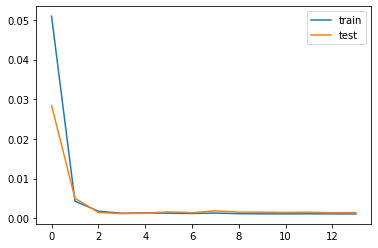

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
model.load_weights(file_path)
os.remove(file_path)

In [24]:
def evaluate_model(trained_model, train, test, actual):

    X_train_prediction = trained_model.predict(train)
    X_test_prediction = trained_model.predict(test)

    plt.figure(figsize=(20,10))

    plt.plot(scaler.inverse_transform(actual.reshape(-1,1)), label="Actual")
    plt.plot(scaler.inverse_transform(X_train_prediction), label="Train", alpha=0.8)
    plt.plot(np.linspace(7565,7565 + len(X_test_prediction), len(X_test_prediction)), scaler.inverse_transform(X_test_prediction), label="Test", color='orange', alpha=0.8)
    plt.legend(fontsize="xx-large")

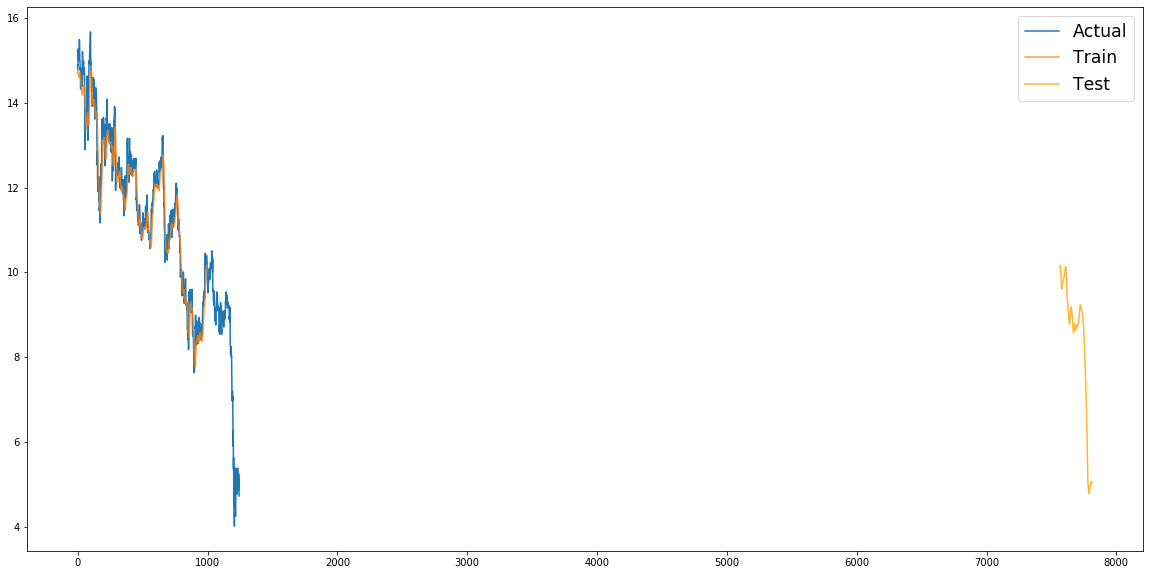

In [25]:
evaluate_model(model, X_train, X_test, y)

In [26]:
def predict(input_value):

    Xt = model.predict(input_value.reshape(1,look_back,1))
 
    return scaler.inverse_transform(Xt)[0][0]

In [27]:

i = X_test.shape[0] - 1

# Make sure input is scaled
prediction = predict(X_test[i])

actual_value = scaler.inverse_transform(y_test[i].reshape(-1,1))[0][0]

print('Predicted: {0:.4f}, Actual: {1:.4f}'.format(prediction, actual_value))

accuracy = (prediction / actual_value) * 100

print('Accuracy:{0:.2f}%'.format(accuracy))

Predicted: 5.0433, Actual: 4.7200
Accuracy:106.85%


In [11]:
#convert data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

Xarr: [[1.5270000e+01 1.5490000e+01 1.5270000e+01 1.5480000e+01 1.1977631e+01
  1.8937700e+07]
 [1.5470000e+01 1.5640000e+01 1.5450000e+01 1.5580000e+01 1.2055005e+01
  1.9491900e+07]
 [1.5590000e+01 1.5630000e+01 1.5450000e+01 1.5500000e+01 1.1993106e+01
  1.5145300e+07]
 [1.5540000e+01 1.5560000e+01 1.5260000e+01 1.5300000e+01 1.1838357e+01
  2.2391500e+07]
 [1.5280000e+01 1.5550000e+01 1.5260000e+01 1.5510000e+01 1.2000844e+01
  2.3962000e+07]]
yarr: [[15.49]
 [15.64]
 [15.63]
 [15.56]
 [15.55]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [15.64 15.63 15.56 15.55 15.5 ]
X shape: (1258, 6)
y shape: (1258,)


In [66]:

train_pct = 0.80

X_train,X_test = Xarr[:int(Xarr.shape[0]*train_pct)],Xarr[int(Xarr.shape[0]*train_pct):]
y_train,y_test = yarr[:int(yarr.shape[0]*train_pct)],yarr[int(yarr.shape[0]*train_pct):]
Date_train,Date_test = Datearr[:int(Datearr.shape[0]*train_pct)],Datearr[int(Datearr.shape[0]*train_pct):]

#Reshape data into (Sample,Timestep,Features) 
#X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(Date_test.shape)
print(Date_train.shape)

(1006, 6)
(252, 6)
(1006,)
(252,)
(252,)
(1007,)


In [61]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
# define dataset
#X = array([[100, 110, 120], [110, 120, 130], [120, 130, 140], [130, 140, 150], [140, 150, 160]])
#y = array([130, 140, 150, 160, 170])
#print('X', X)
#print('y', y)
# define model
#model = Sequential()
#model.add(Dense(100, activation='relu', input_dim=6))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')
# fit model
# model.fit(X, y, epochs=2000, verbose=0)
#history = model.fit(X_train, y_train, epochs=20, verbose=0, validation_data = (X_test,y_test))

file_path = 'daily_lstm_model_weights.h5'

callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)

callbacks = [early_stopping, callback_checkpoint, reduce_lr]

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))

#model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(200,activation='relu'))

model.add(tf.keras.layers.Dense(1))

#optimize = tf.keras.optimizers.Adam(lr=0.03,decay = 0.001)
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [62]:
model.summary()
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 200)               1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1 samples
Epoch 1/1000
200/200 [==============================] - 0s 1ms/sample - loss: 18488685011927.0391 - accuracy: 0.0000e+00 - val_loss: 3783535624192.0000 - val_accuracy: 0.0000e+00
Epoch 2/1000
200/200 [==============================] - 0s 96us/sample - loss: 749747600097.2800 - accuracy: 0.0000e+00 - val_loss: 1347260776448.0000 - val_accu

200/200 [==============================] - 0s 57us/sample - loss: 113.3483 - accuracy: 0.0000e+00 - val_loss: 1.5505 - val_accuracy: 0.0000e+00
Epoch 46/1000
200/200 [==============================] - 0s 75us/sample - loss: 112.6826 - accuracy: 0.0000e+00 - val_loss: 1.5505 - val_accuracy: 0.0000e+00
Epoch 47/1000
200/200 [==============================] - 0s 62us/sample - loss: 111.4503 - accuracy: 0.0000e+00 - val_loss: 1.6293 - val_accuracy: 0.0000e+00
Epoch 48/1000
200/200 [==============================] - 0s 66us/sample - loss: 112.2250 - accuracy: 0.0000e+00 - val_loss: 1.7101 - val_accuracy: 0.0000e+00
Epoch 49/1000
200/200 [==============================] - 0s 61us/sample - loss: 112.9264 - accuracy: 0.0000e+00 - val_loss: 2.3300 - val_accuracy: 0.0000e+00
Epoch 50/1000
200/200 [==============================] - 0s 63us/sample - loss: 112.9202 - accuracy: 0.0000e+00 - val_loss: 2.3300 - val_accuracy: 0.0000e+00
Epoch 00050: early stopping


x_input [[1.3060000e+01 1.3350000e+01 1.3040000e+01 1.3220000e+01 1.0567935e+01
  3.6598200e+07]]
yhat [[12.083557]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 200)               1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
loss: 112.920168
loss: 112.92016845703125


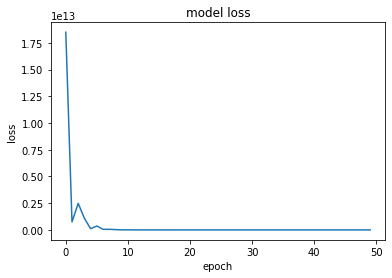

In [63]:
# demonstrate prediction
x_input = X_test
#x_input = x_input.reshape((1, 3))
yhat = model.predict(x_input, verbose=0)
print('x_input', x_input)
print('yhat', yhat)
print(model.summary())

# list all data in history
print(history.history.keys())
# summarize history for loss
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [69]:
def evaluate_model(trained_model, x_test,y_test):

    #X_train_prediction = trained_model.predict(train)
    X_test_prediction = trained_model.predict(x_test)

    plt.figure(figsize=(20,10))
    print(len(y_test))

    plt.plot((y_test.reshape(-1,1)), label="Actual")
    plt.plot(X_test_prediction, label="Train", alpha=0.8,color ='orange')
    index = np.arange(252,step=25)
    dates = Date_test[index]
    plt.xticks(index,dates)
    print(type(Date_test),type(index))
    #plt.plot(np.linspace(7565,7565 + len(X_test_prediction), len(X_test_prediction)), X_test_prediction, label="Test", color='orange', alpha=0.8)
    plt.legend(fontsize="xx-large")

252
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


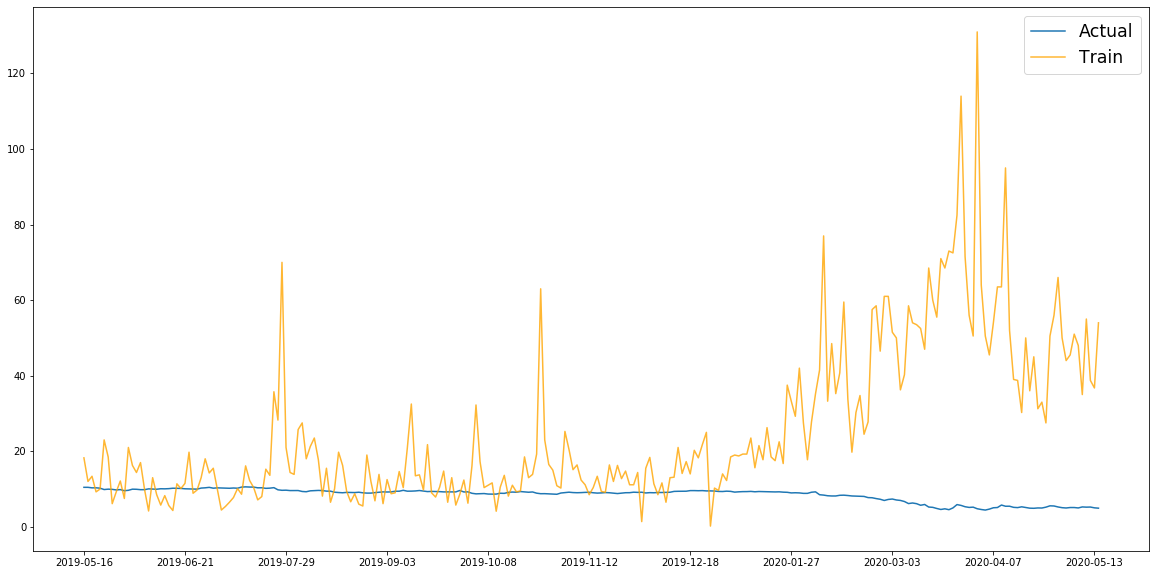

In [70]:
evaluate_model(model, X_test, y_test)

# Sliding Window:

In [72]:
def build_data(start,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+1]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+1]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+1]
    return X_train,X_test,y_train,y_test,Date_train,Date_test


X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(Date_train.shape)
print(Date_test.shape)

(200, 6)
(1, 6)
(200,)
(1,)
(200,)
(1,)


In [73]:
Date_train

array(['2015-05-15', '2015-05-18', '2015-05-19', '2015-05-20',
       '2015-05-21', '2015-05-22', '2015-05-26', '2015-05-27',
       '2015-05-28', '2015-05-29', '2015-06-01', '2015-06-02',
       '2015-06-03', '2015-06-04', '2015-06-05', '2015-06-08',
       '2015-06-09', '2015-06-10', '2015-06-11', '2015-06-12',
       '2015-06-15', '2015-06-16', '2015-06-17', '2015-06-18',
       '2015-06-19', '2015-06-22', '2015-06-23', '2015-06-24',
       '2015-06-25', '2015-06-26', '2015-06-29', '2015-06-30',
       '2015-07-01', '2015-07-02', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-13',
       '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17',
       '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
       '2015-07-24', '2015-07-27', '2015-07-28', '2015-07-29',
       '2015-07-30', '2015-07-31', '2015-08-03', '2015-08-04',
       '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-10',
       '2015-08-11', '2015-08-12', '2015-08-13', '2015-

In [74]:
trn_size = len(Xarr)
trn_size

1258

In [77]:
predicted_high = []
actual_high = []
predicted_dates = []
for trn in range(0,trn_size-200):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    predicted_dates.append(Date_test[0])
    actual_high.append(y_test[0])
    

0
Epoch 00018: early stopping
1
Epoch 00020: early stopping
2
Epoch 00015: early stopping
3
Epoch 00016: early stopping
4
Epoch 00020: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00017: early stopping
8
Epoch 00018: early stopping
9
Epoch 00013: early stopping
10
Epoch 00018: early stopping
11
Epoch 00015: early stopping
12
Epoch 00028: early stopping
13
Epoch 00014: early stopping
14
Epoch 00013: early stopping
15
Epoch 00014: early stopping
16
Epoch 00012: early stopping
17
Epoch 00011: early stopping
18
Epoch 00011: early stopping
19
Epoch 00034: early stopping
20
Epoch 00041: early stopping
21
Epoch 00013: early stopping
22
Epoch 00015: early stopping
23
Epoch 00011: early stopping
24
Epoch 00028: early stopping
25
Epoch 00011: early stopping
26
Epoch 00032: early stopping
27
Epoch 00011: early stopping
28
Epoch 00011: early stopping
29
Epoch 00034: early stopping
30
Epoch 00011: early stopping
31
Epoch 00013: early stopping
32
Epoch 00013: ea

Epoch 00011: early stopping
261
Epoch 00014: early stopping
262
Epoch 00018: early stopping
263
Epoch 00030: early stopping
264
Epoch 00017: early stopping
265
Epoch 00011: early stopping
266
Epoch 00014: early stopping
267
Epoch 00011: early stopping
268
Epoch 00053: early stopping
269
Epoch 00011: early stopping
270
Epoch 00027: early stopping
271
Epoch 00034: early stopping
272
Epoch 00019: early stopping
273
Epoch 00015: early stopping
274
Epoch 00054: early stopping
275
Epoch 00012: early stopping
276
Epoch 00014: early stopping
277
Epoch 00036: early stopping
278
Epoch 00023: early stopping
279
Epoch 00012: early stopping
280
Epoch 00025: early stopping
281
Epoch 00019: early stopping
282
Epoch 00027: early stopping
283
Epoch 00012: early stopping
284
Epoch 00014: early stopping
285
Epoch 00012: early stopping
286
Epoch 00011: early stopping
287
Epoch 00011: early stopping
288
Epoch 00028: early stopping
289
Epoch 00016: early stopping
290
Epoch 00014: early stopping
291
Epoch 00

518
Epoch 00014: early stopping
519
Epoch 00023: early stopping
520
Epoch 00015: early stopping
521
Epoch 00026: early stopping
522
Epoch 00013: early stopping
523
Epoch 00017: early stopping
524
Epoch 00020: early stopping
525
Epoch 00014: early stopping
526
Epoch 00039: early stopping
527
Epoch 00014: early stopping
528
Epoch 00018: early stopping
529
Epoch 00015: early stopping
530
Epoch 00011: early stopping
531
Epoch 00011: early stopping
532
Epoch 00013: early stopping
533
Epoch 00019: early stopping
534
Epoch 00011: early stopping
535
Epoch 00043: early stopping
536
Epoch 00011: early stopping
537
Epoch 00035: early stopping
538
Epoch 00011: early stopping
539
Epoch 00026: early stopping
540
Epoch 00014: early stopping
541
Epoch 00011: early stopping
542
Epoch 00038: early stopping
543
Epoch 00011: early stopping
544
Epoch 00011: early stopping
545
Epoch 00034: early stopping
546
Epoch 00011: early stopping
547
Epoch 00032: early stopping
548
Epoch 00012: early stopping
549
Epoc

Epoch 00026: early stopping
775
Epoch 00023: early stopping
776
Epoch 00015: early stopping
777
Epoch 00017: early stopping
778
Epoch 00011: early stopping
779
Epoch 00011: early stopping
780
Epoch 00011: early stopping
781
Epoch 00036: early stopping
782
Epoch 00013: early stopping
783
Epoch 00011: early stopping
784
Epoch 00020: early stopping
785
Epoch 00011: early stopping
786
Epoch 00037: early stopping
787
Epoch 00031: early stopping
788
Epoch 00011: early stopping
789
Epoch 00028: early stopping
790
Epoch 00028: early stopping
791
Epoch 00038: early stopping
792
Epoch 00012: early stopping
793
Epoch 00028: early stopping
794
Epoch 00017: early stopping
795
Epoch 00023: early stopping
796
Epoch 00025: early stopping
797
Epoch 00012: early stopping
798
Epoch 00011: early stopping
799
Epoch 00011: early stopping
800
Epoch 00011: early stopping
801
Epoch 00013: early stopping
802
Epoch 00011: early stopping
803
Epoch 00011: early stopping
804
Epoch 00011: early stopping
805
Epoch 00

Epoch 00034: early stopping
1031
Epoch 00020: early stopping
1032
Epoch 00011: early stopping
1033
Epoch 00038: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00011: early stopping
1036
Epoch 00044: early stopping
1037
Epoch 00015: early stopping
1038
Epoch 00017: early stopping
1039
Epoch 00012: early stopping
1040
Epoch 00011: early stopping
1041
Epoch 00045: early stopping
1042
Epoch 00012: early stopping
1043
Epoch 00021: early stopping
1044
Epoch 00015: early stopping
1045
Epoch 00011: early stopping
1046
Epoch 00034: early stopping
1047
Epoch 00015: early stopping
1048
Epoch 00015: early stopping
1049
Epoch 00011: early stopping
1050
Epoch 00038: early stopping
1051
Epoch 00025: early stopping
1052
Epoch 00012: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00037: early stopping
1055
Epoch 00030: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00011: early stopping


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


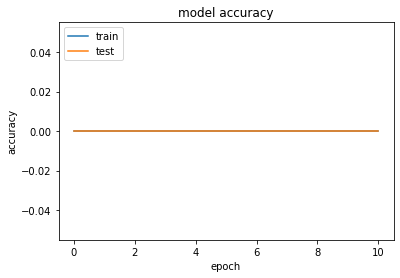

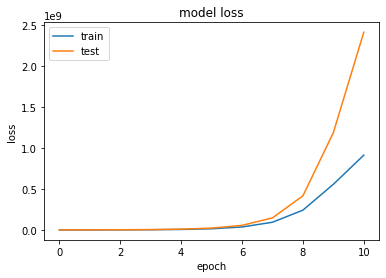

In [78]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Mean Absolute Error= [[6070.663]]
loss: 912141529.520000


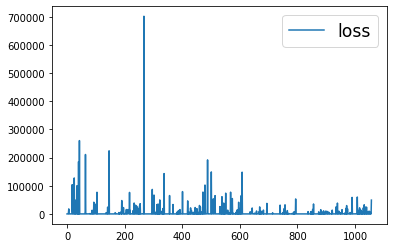

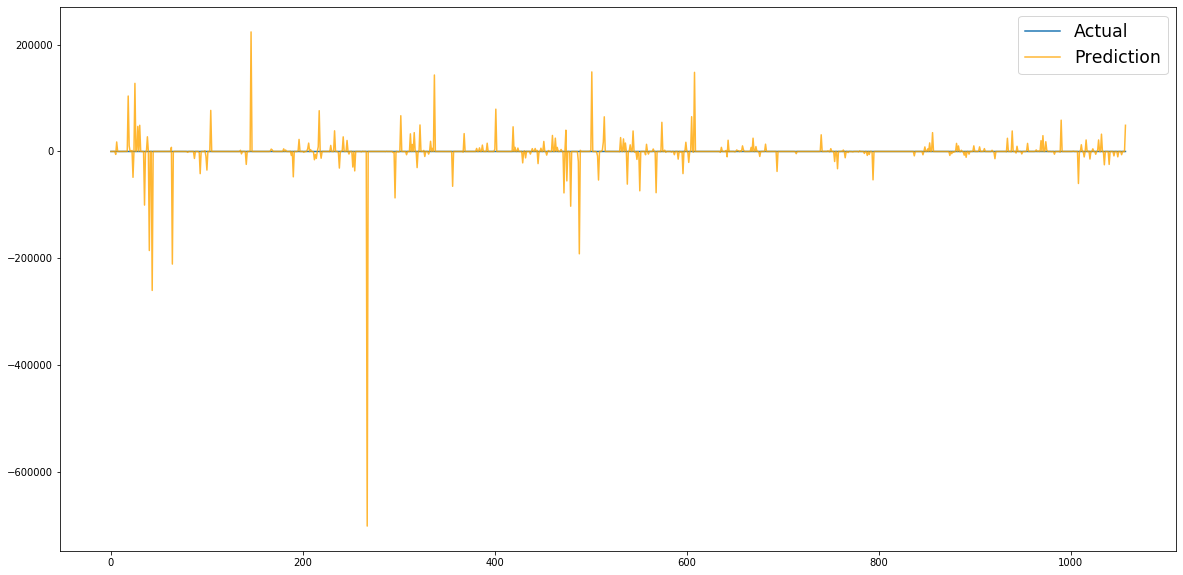

In [81]:
def mae(y_predicted,y_actual):
    n = len(y_predicted)
    loss = []
    error = 0
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
        error = error + abs(y_predicted[i] - y_actual[i])
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")
    error = error/n
    return error
        
def evaluate_model(y_predicted,y_actual,dates):
    
    print('loss:', '%f'%history.history['loss'][-1])
    plt.figure(figsize=(20,10))

    plt.plot((y_actual.reshape(-1,1)), label="Actual")
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8,color ='orange')
    plt.legend(fontsize="xx-large")


print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high),predicted_dates)

print(history)

#print(np.array(predicted_high).shape, np.array(actual_high).shape)

In [143]:
np.array(predicted_high).tolist()

[[[13.172673225402832]],
 [[14.29769229888916]],
 [[12.805535316467285]],
 [[25.926673889160156]],
 [[13.649359703063965]],
 [[13.352531433105469]],
 [[12.547865867614746]],
 [[27.90727996826172]],
 [[11.794024467468262]],
 [[12.555764198303223]],
 [[13.548129081726074]],
 [[11.630192756652832]],
 [[11.942727088928223]],
 [[10.196677207946777]],
 [[9.489694595336914]],
 [[17.895986557006836]],
 [[21.02492904663086]],
 [[15.480042457580566]],
 [[18.7711181640625]],
 [[19.79460906982422]],
 [[22.853254318237305]],
 [[33.798614501953125]],
 [[24.61897850036621]],
 [[21.11121940612793]],
 [[17.337881088256836]],
 [[22.646631240844727]],
 [[15.822470664978027]],
 [[18.54910659790039]],
 [[16.63509750366211]],
 [[19.326589584350586]],
 [[16.89311408996582]],
 [[16.92832374572754]],
 [[18.901071548461914]],
 [[18.463638305664062]],
 [[19.561389923095703]],
 [[20.315448760986328]],
 [[17.11239242553711]],
 [[14.608587265014648]],
 [[19.358638763427734]],
 [[17.636112213134766]],
 [[32.60492324

In [144]:
np.array(actual_high).tolist()

[13.61,
 13.86,
 13.74,
 13.58,
 13.32,
 13.28,
 13.3,
 13.37,
 13.24,
 13.51,
 13.68,
 13.7,
 13.76,
 13.73,
 13.61,
 13.12,
 13.17,
 13.2,
 13.44,
 13.52,
 13.33,
 13.12,
 12.85,
 12.87,
 12.79,
 12.78,
 12.8,
 12.84,
 13.12,
 13.18,
 13.12,
 13.28,
 13.5,
 13.72,
 13.88,
 13.78,
 13.65,
 13.82,
 13.71,
 14.22,
 14.03,
 13.79,
 13.55,
 13.38,
 13.43,
 13.48,
 13.5,
 13.52,
 13.54,
 13.47,
 13.52,
 13.38,
 13.31,
 13.34,
 13.2,
 13.26,
 13.2,
 13.3,
 13.6,
 13.68,
 13.54,
 13.56,
 13.44,
 13.32,
 13.14,
 13.21,
 13.45,
 13.49,
 13.3,
 13.25,
 13.13,
 13.07,
 13.16,
 13.14,
 13.4,
 13.55,
 13.44,
 13.31,
 13.41,
 12.91,
 12.43,
 12.44,
 12.58,
 12.57,
 12.89,
 12.59,
 12.58,
 12.84,
 13.17,
 13.33,
 13.54,
 13.51,
 13.7,
 13.67,
 13.68,
 13.72,
 13.78,
 14.04,
 13.93,
 13.95,
 13.88,
 13.99,
 12.86,
 12.88,
 12.62,
 12.36,
 12.2,
 12.23,
 12.26,
 12.33,
 12.38,
 12.36,
 12.37,
 12.37,
 12.44,
 12.43,
 12.39,
 12.36,
 12.41,
 12.38,
 12.43,
 12.44,
 12.52,
 12.55,
 12.5,
 12.56,
 12.61,

# Model 2:

In [145]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(200,activation='relu'))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(100,activation='relu'))

model.add(tf.keras.layers.Dense(1))

#optimize = tf.keras.optimizers.Adam(lr=0.03,decay = 0.001)
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [146]:
#train model:
predicted_high = []
actual_high = []
for trn in range(0,trn_size-200):
    X_train,X_test,y_train,y_test = build_data(trn)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])
    

0
Epoch 00014: early stopping
1
Epoch 00232: early stopping
2
Epoch 00014: early stopping
3
Epoch 00016: early stopping
4
Epoch 00020: early stopping
5
Epoch 00012: early stopping
6
Epoch 00017: early stopping
7
Epoch 00030: early stopping
8
Epoch 00011: early stopping
9
Epoch 00012: early stopping
10
Epoch 00017: early stopping
11
Epoch 00011: early stopping
12
Epoch 00012: early stopping
13
Epoch 00015: early stopping
14
Epoch 00013: early stopping
15
Epoch 00011: early stopping
16
Epoch 00018: early stopping
17
Epoch 00028: early stopping
18
Epoch 00020: early stopping
19
Epoch 00015: early stopping
20
Epoch 00017: early stopping
21
Epoch 00016: early stopping
22
Epoch 00011: early stopping
23
Epoch 00015: early stopping
24
Epoch 00039: early stopping
25
Epoch 00022: early stopping
26
Epoch 00011: early stopping
27
Epoch 00017: early stopping
28
Epoch 00041: early stopping
29
Epoch 00024: early stopping
30
Epoch 00028: early stopping
31
Epoch 00011: early stopping
32
Epoch 00018: ea

261
Epoch 00016: early stopping
262
Epoch 00029: early stopping
263
Epoch 00019: early stopping
264
Epoch 00017: early stopping
265
Epoch 00011: early stopping
266
Epoch 00013: early stopping
267
Epoch 00012: early stopping
268
Epoch 00011: early stopping
269
Epoch 00019: early stopping
270
Epoch 00015: early stopping
271
Epoch 00011: early stopping
272
Epoch 00012: early stopping
273
Epoch 00016: early stopping
274
Epoch 00011: early stopping
275
Epoch 00012: early stopping
276
Epoch 00012: early stopping
277
Epoch 00079: early stopping
278
Epoch 00017: early stopping
279
Epoch 00017: early stopping
280
Epoch 00018: early stopping
281
Epoch 00011: early stopping
282
Epoch 00012: early stopping
283
Epoch 00016: early stopping
284
Epoch 00073: early stopping
285
Epoch 00019: early stopping
286
Epoch 00012: early stopping
287
Epoch 00014: early stopping
288
Epoch 00012: early stopping
289
Epoch 00011: early stopping
290
Epoch 00011: early stopping
291
Epoch 00014: early stopping
292
Epoc

518
Epoch 00012: early stopping
519
Epoch 00017: early stopping
520
Epoch 00013: early stopping
521
Epoch 00014: early stopping
522
Epoch 00011: early stopping
523
Epoch 00081: early stopping
524
Epoch 00011: early stopping
525
Epoch 00059: early stopping
526
Epoch 00013: early stopping
527
Epoch 00016: early stopping
528
Epoch 00024: early stopping
529
Epoch 00018: early stopping
530
Epoch 00018: early stopping
531
Epoch 00030: early stopping
532
Epoch 00022: early stopping
533
Epoch 00041: early stopping
534
Epoch 00011: early stopping
535
Epoch 00013: early stopping
536
Epoch 00013: early stopping
537
Epoch 00014: early stopping
538
Epoch 00013: early stopping
539
Epoch 00111: early stopping
540
Epoch 00020: early stopping
541
Epoch 00011: early stopping
542
Epoch 00013: early stopping
543
Epoch 00012: early stopping
544
Epoch 00011: early stopping
545
Epoch 00045: early stopping
546
Epoch 00013: early stopping
547
Epoch 00098: early stopping
548
Epoch 00020: early stopping
549
Epoc

Epoch 00014: early stopping
775
Epoch 00011: early stopping
776
Epoch 00027: early stopping
777
Epoch 00152: early stopping
778
Epoch 00013: early stopping
779
Epoch 00011: early stopping
780
Epoch 00013: early stopping
781
Epoch 00012: early stopping
782
Epoch 00013: early stopping
783
Epoch 00011: early stopping
784
Epoch 00016: early stopping
785
Epoch 00027: early stopping
786
Epoch 00020: early stopping
787
Epoch 00015: early stopping
788
Epoch 00012: early stopping
789
Epoch 00017: early stopping
790
Epoch 00012: early stopping
791
Epoch 00086: early stopping
792
Epoch 00012: early stopping
793
Epoch 00011: early stopping
794
Epoch 00013: early stopping
795
Epoch 00028: early stopping
796
Epoch 00013: early stopping
797
Epoch 00011: early stopping
798
Epoch 00024: early stopping
799
Epoch 00012: early stopping
800
Epoch 00018: early stopping
801
Epoch 00068: early stopping
802
Epoch 00011: early stopping
803
Epoch 00011: early stopping
804
Epoch 00016: early stopping
805
Epoch 00

1031
Epoch 00011: early stopping
1032
Epoch 00015: early stopping
1033
Epoch 00011: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00011: early stopping
1036
Epoch 00015: early stopping
1037
Epoch 00011: early stopping
1038
Epoch 00041: early stopping
1039
Epoch 00211: early stopping
1040
Epoch 00014: early stopping
1041
Epoch 00011: early stopping
1042
Epoch 00012: early stopping
1043
Epoch 00014: early stopping
1044
Epoch 00013: early stopping
1045
Epoch 00012: early stopping
1046
Epoch 00073: early stopping
1047
Epoch 00014: early stopping
1048
Epoch 00098: early stopping
1049
Epoch 00011: early stopping
1050
Epoch 00011: early stopping
1051
Epoch 00013: early stopping
1052
Epoch 00011: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00011: early stopping
1055
Epoch 00011: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00011: early stopping


Mean Absolute Error= [[1.8971398]]
(1058, 1, 1) (1058,)


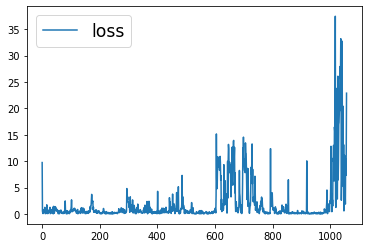

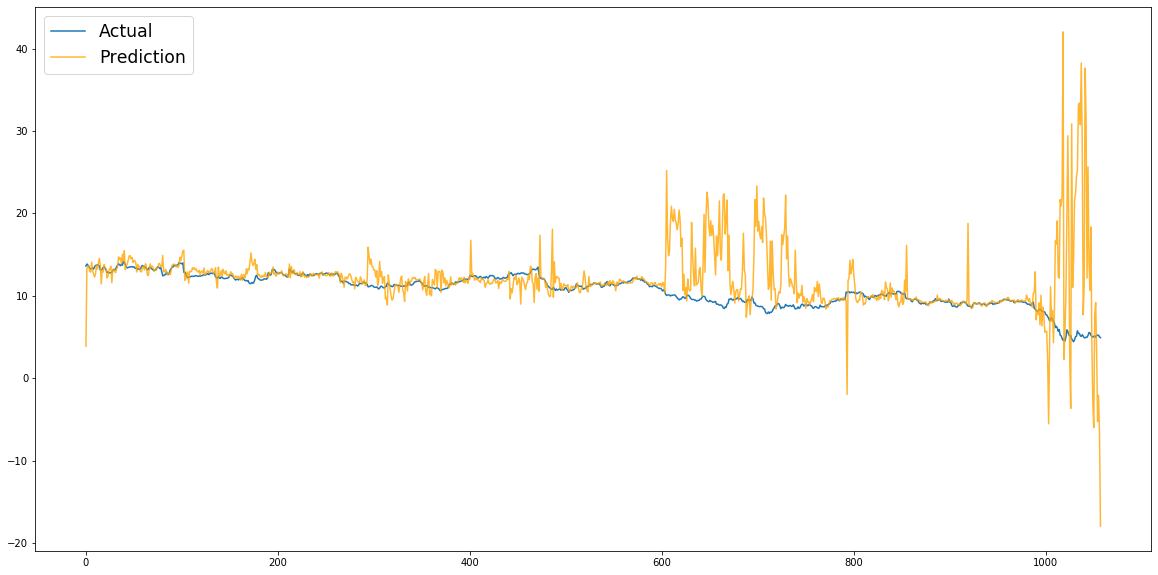

In [147]:
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 3:

In [148]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(200,activation='relu'))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(100,activation='relu'))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(50,activation='relu'))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(30,activation='relu'))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

#optimize = tf.keras.optimizers.Adam(lr=0.03,decay = 0.001)
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [149]:
#train model:
predicted_high = []
actual_high = []
for trn in range(0,trn_size-200):
    X_train,X_test,y_train,y_test = build_data(trn)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00092: early stopping
1
Epoch 00017: early stopping
2
Epoch 00011: early stopping
3
Epoch 00019: early stopping
4
Epoch 00018: early stopping
5
Epoch 00011: early stopping
6
Epoch 00066: early stopping
7
Epoch 00012: early stopping
8
Epoch 00024: early stopping
9
Epoch 00047: early stopping
10
Epoch 00026: early stopping
11
Epoch 00014: early stopping
12
Epoch 00057: early stopping
13
Epoch 00011: early stopping
14
Epoch 00013: early stopping
15
Epoch 00017: early stopping
16
Epoch 00018: early stopping
17
Epoch 00025: early stopping
18
Epoch 00011: early stopping
19
Epoch 00015: early stopping
20
Epoch 00011: early stopping
21
Epoch 00018: early stopping
22
Epoch 00013: early stopping
23
Epoch 00012: early stopping
24
Epoch 00020: early stopping
25
Epoch 00014: early stopping
26
Epoch 00012: early stopping
27
Epoch 00021: early stopping
28
Epoch 00011: early stopping
29
Epoch 00014: early stopping
30
Epoch 00053: early stopping
31
Epoch 00016: early stopping
32
Epoch 00013: ea

Epoch 00014: early stopping
261
Epoch 00081: early stopping
262
Epoch 00015: early stopping
263
Epoch 00011: early stopping
264
Epoch 00021: early stopping
265
Epoch 00067: early stopping
266
Epoch 00022: early stopping
267
Epoch 00013: early stopping
268
Epoch 00013: early stopping
269
Epoch 00017: early stopping
270
Epoch 00011: early stopping
271
Epoch 00014: early stopping
272
Epoch 00014: early stopping
273
Epoch 00014: early stopping
274
Epoch 00011: early stopping
275
Epoch 00013: early stopping
276
Epoch 00011: early stopping
277
Epoch 00012: early stopping
278
Epoch 00012: early stopping
279
Epoch 00013: early stopping
280
Epoch 00015: early stopping
281
Epoch 00012: early stopping
282
Epoch 00016: early stopping
283
Epoch 00014: early stopping
284
Epoch 00011: early stopping
285
Epoch 00014: early stopping
286
Epoch 00013: early stopping
287
Epoch 00027: early stopping
288
Epoch 00020: early stopping
289
Epoch 00018: early stopping
290
Epoch 00013: early stopping
291
Epoch 00

Epoch 00014: early stopping
518
Epoch 00011: early stopping
519
Epoch 00014: early stopping
520
Epoch 00011: early stopping
521
Epoch 00011: early stopping
522
Epoch 00011: early stopping
523
Epoch 00011: early stopping
524
Epoch 00020: early stopping
525
Epoch 00017: early stopping
526
Epoch 00011: early stopping
527
Epoch 00011: early stopping
528
Epoch 00020: early stopping
529
Epoch 00103: early stopping
530
Epoch 00016: early stopping
531
Epoch 00013: early stopping
532
Epoch 00013: early stopping
533
Epoch 00013: early stopping
534
Epoch 00013: early stopping
535
Epoch 00013: early stopping
536
Epoch 00028: early stopping
537
Epoch 00018: early stopping
538
Epoch 00014: early stopping
539
Epoch 00016: early stopping
540
Epoch 00041: early stopping
541
Epoch 00014: early stopping
542
Epoch 00013: early stopping
543
Epoch 00012: early stopping
544
Epoch 00031: early stopping
545
Epoch 00017: early stopping
546
Epoch 00011: early stopping
547
Epoch 00011: early stopping
548
Epoch 00

Epoch 00012: early stopping
775
Epoch 00011: early stopping
776
Epoch 00011: early stopping
777
Epoch 00015: early stopping
778
Epoch 00019: early stopping
779
Epoch 00011: early stopping
780
Epoch 00011: early stopping
781
Epoch 00011: early stopping
782
Epoch 00012: early stopping
783
Epoch 00011: early stopping
784
Epoch 00013: early stopping
785
Epoch 00014: early stopping
786
Epoch 00011: early stopping
787
Epoch 00029: early stopping
788
Epoch 00011: early stopping
789
Epoch 00020: early stopping
790
Epoch 00011: early stopping
791
Epoch 00011: early stopping
792
Epoch 00013: early stopping
793
Epoch 00034: early stopping
794
Epoch 00071: early stopping
795
Epoch 00021: early stopping
796
Epoch 00013: early stopping
797
Epoch 00011: early stopping
798
Epoch 00016: early stopping
799
Epoch 00011: early stopping
800
Epoch 00011: early stopping
801
Epoch 00011: early stopping
802
Epoch 00015: early stopping
803
Epoch 00011: early stopping
804
Epoch 00016: early stopping
805
Epoch 00

Epoch 00017: early stopping
1031
Epoch 00020: early stopping
1032
Epoch 00015: early stopping
1033
Epoch 00011: early stopping
1034
Epoch 00020: early stopping
1035
Epoch 00014: early stopping
1036
Epoch 00016: early stopping
1037
Epoch 00057: early stopping
1038
Epoch 00018: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00024: early stopping
1041
Epoch 00011: early stopping
1042
Epoch 00012: early stopping
1043
Epoch 00012: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00016: early stopping
1046
Epoch 00018: early stopping
1047
Epoch 00013: early stopping
1048
Epoch 00015: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00011: early stopping
1051
Epoch 00012: early stopping
1052
Epoch 00014: early stopping
1053
Epoch 00026: early stopping
1054
Epoch 00014: early stopping
1055
Epoch 00036: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00017: early stopping


Mean Absolute Error= [[11.578111]]
(1058, 1, 1) (1058,)


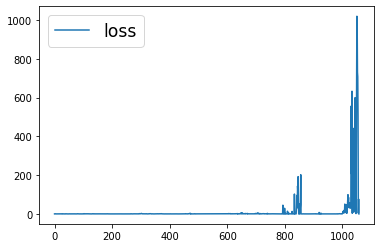

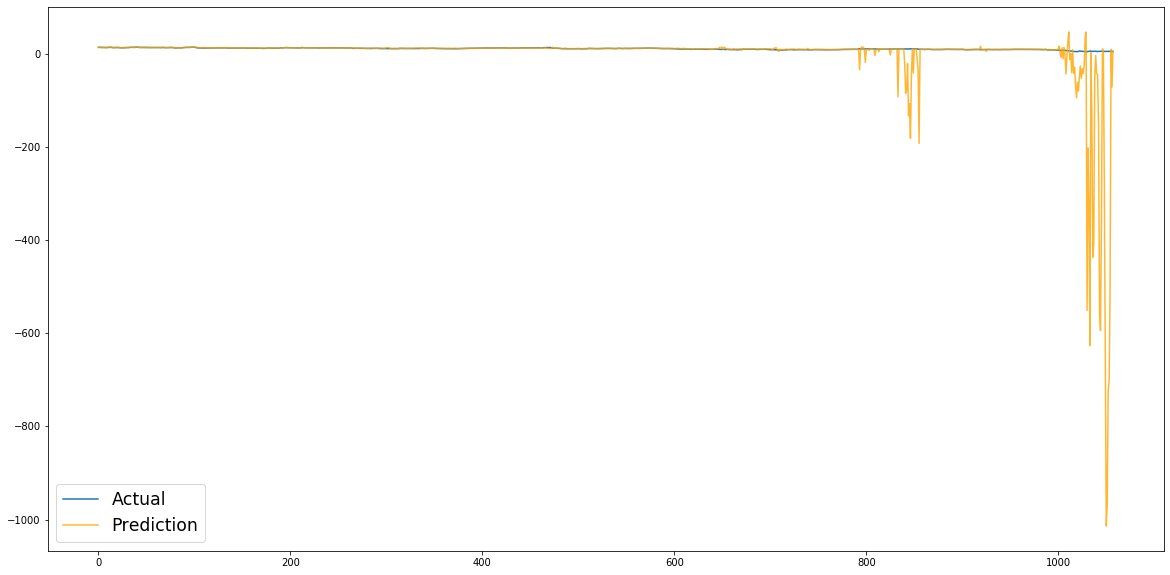

In [150]:
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

In [155]:
X = array([[100, 110, 120], [110, 120, 130], [120, 130, 140], [130, 140, 150], [140, 150, 160]])
y = array([130, 140, 150, 160, 170])
# reshape from [samples, timesteps] into [samples, timesteps, features]
print(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
print((X.shape[0], X.shape[1], 1))

[[100 110 120]
 [110 120 130]
 [120 130 140]
 [130 140 150]
 [140 150 160]]
(5, 3, 1)


In [160]:
Xarr.shape
Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1)).shape

(1258, 6, 1)

# Model 4: CNN

In [170]:
# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline
# define dataset
#X = array([[100, 110, 120], [110, 120, 130], [120, 130, 140], [130, 140, 150], [140, 150, 160]])
#y = array([130, 140, 150, 160, 170])
# reshape from [samples, timesteps] into [samples, timesteps, features]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 5, 64)             192       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
_________________________________________________________________


In [165]:
#train model:
predicted_high = []
actual_high = []
for trn in range(0,trn_size-200):
    X_train,X_test,y_train,y_test = build_data(trn)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00020: early stopping
1
Epoch 00011: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
Epoch 00012: early stopping
5
Epoch 00012: early stopping
6
Epoch 00011: early stopping
7
Epoch 00012: early stopping
8
Epoch 00012: early stopping
9
Epoch 00013: early stopping
10
Epoch 00278: early stopping
11
Epoch 00011: early stopping
12
Epoch 00011: early stopping
13
Epoch 00011: early stopping
14
Epoch 00011: early stopping
15
Epoch 00012: early stopping
16
Epoch 00017: early stopping
17
Epoch 00011: early stopping
18
Epoch 00015: early stopping
19
Epoch 00012: early stopping
20
Epoch 00203: early stopping
21
Epoch 00011: early stopping
22
Epoch 00040: early stopping
23
Epoch 00022: early stopping
24
Epoch 00082: early stopping
25
Epoch 00062: early stopping
26
Epoch 00020: early stopping
27
Epoch 00014: early stopping
28
Epoch 00011: early stopping
29
Epoch 00014: early stopping
30
Epoch 00011: early stopping
31
Epoch 00015: early stopping
32
Epoch 00014: ea

Epoch 00014: early stopping
263
Epoch 00012: early stopping
264
Epoch 00011: early stopping
265
Epoch 00012: early stopping
266
Epoch 00011: early stopping
267
Epoch 00011: early stopping
268
Epoch 00014: early stopping
269
Epoch 00014: early stopping
270
Epoch 00015: early stopping
271
Epoch 00011: early stopping
272
Epoch 00011: early stopping
273
Epoch 00011: early stopping
274
Epoch 00011: early stopping
275
Epoch 00022: early stopping
276
Epoch 00233: early stopping
277
Epoch 00014: early stopping
278
Epoch 00011: early stopping
279
Epoch 00101: early stopping
280
Epoch 00012: early stopping
281
Epoch 00012: early stopping
282
Epoch 00015: early stopping
283
Epoch 00014: early stopping
284
Epoch 00018: early stopping
285
Epoch 00013: early stopping
286
Epoch 00014: early stopping
287
Epoch 00014: early stopping
288
Epoch 00015: early stopping
289
Epoch 00013: early stopping
290
Epoch 00015: early stopping
291
Epoch 00011: early stopping
292
Epoch 00014: early stopping
293
Epoch 00

Epoch 00136: early stopping
520
Epoch 00011: early stopping
521
Epoch 00011: early stopping
522
Epoch 00011: early stopping
523
Epoch 00017: early stopping
524
Epoch 00483: early stopping
525
Epoch 00012: early stopping
526
Epoch 00020: early stopping
527
Epoch 00012: early stopping
528
Epoch 00018: early stopping
529
Epoch 00012: early stopping
530
Epoch 00024: early stopping
531
Epoch 00013: early stopping
532
Epoch 00011: early stopping
533
Epoch 00025: early stopping
534
Epoch 00015: early stopping
535
Epoch 00022: early stopping
536
Epoch 00026: early stopping
537
Epoch 00014: early stopping
538
Epoch 00017: early stopping
539
Epoch 00011: early stopping
540
Epoch 00012: early stopping
541
Epoch 00011: early stopping
542
Epoch 00014: early stopping
543
Epoch 00019: early stopping
544
Epoch 00017: early stopping
545
Epoch 00016: early stopping
546
Epoch 00013: early stopping
547
Epoch 00275: early stopping
548
Epoch 00045: early stopping
549
Epoch 00012: early stopping
550
Epoch 00

Epoch 00051: early stopping
777
Epoch 00011: early stopping
778
Epoch 00020: early stopping
779
Epoch 00018: early stopping
780
Epoch 00025: early stopping
781
Epoch 00019: early stopping
782
Epoch 00013: early stopping
783
Epoch 00018: early stopping
784
Epoch 00021: early stopping
785
Epoch 00012: early stopping
786
Epoch 00021: early stopping
787
Epoch 00012: early stopping
788
Epoch 00018: early stopping
789
Epoch 00011: early stopping
790
Epoch 00019: early stopping
791
Epoch 00052: early stopping
792
Epoch 00016: early stopping
793
Epoch 00014: early stopping
794
Epoch 00079: early stopping
795
Epoch 00049: early stopping
796
Epoch 00012: early stopping
797
Epoch 00424: early stopping
798
Epoch 00014: early stopping
799
Epoch 00011: early stopping
800
Epoch 00013: early stopping
801
Epoch 00011: early stopping
802
Epoch 00013: early stopping
803
Epoch 00133: early stopping
804
Epoch 00013: early stopping
805
Epoch 00011: early stopping
806
Epoch 00076: early stopping
807
Epoch 00

Epoch 00045: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00011: early stopping
1036
Epoch 00014: early stopping
1037
Epoch 00016: early stopping
1038
Epoch 00021: early stopping
1039
Epoch 00044: early stopping
1040
Epoch 00019: early stopping
1041
Epoch 00013: early stopping
1042
Epoch 00011: early stopping
1043
Epoch 00028: early stopping
1044
Epoch 00012: early stopping
1045
Epoch 00015: early stopping
1046
Epoch 00025: early stopping
1047
Epoch 00019: early stopping
1048
Epoch 00012: early stopping
1049
Epoch 00029: early stopping
1050
Epoch 00017: early stopping
1051
Epoch 00015: early stopping
1052
Epoch 00016: early stopping
1053
Epoch 00012: early stopping
1054
Epoch 00016: early stopping
1055
Epoch 00011: early stopping
1056
Epoch 00012: early stopping
1057
Epoch 00048: early stopping


loss: 0.022474
loss: 0.02247434601187706
Mean Absolute Error= [[0.09966055]]
(1058, 1, 1) (1058,)


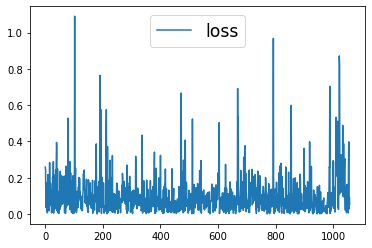

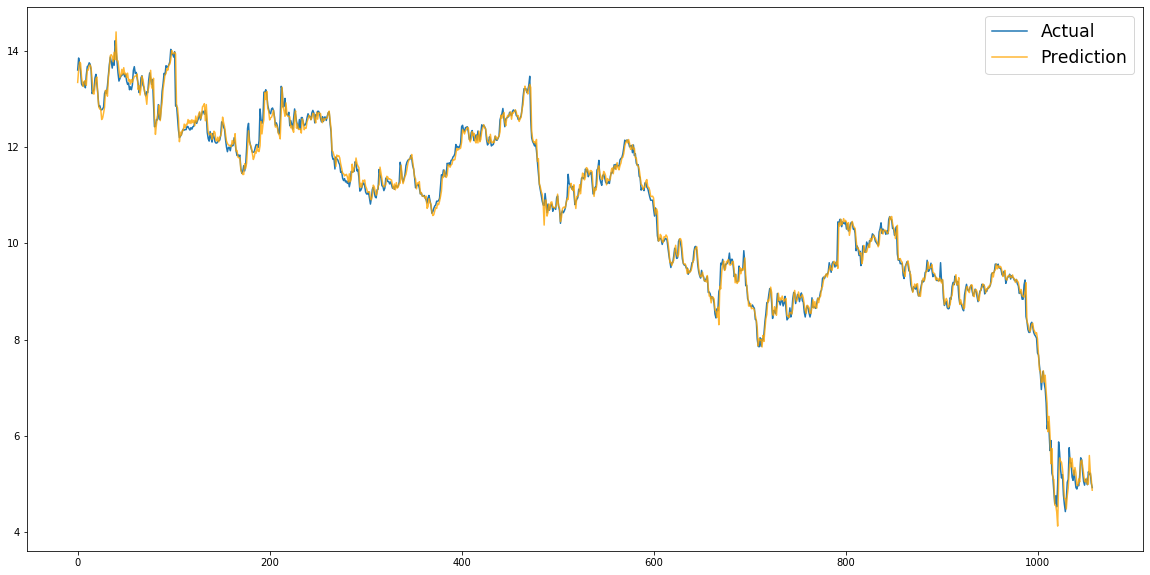

In [166]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 5: CNN2

In [171]:
#train model:
predicted_high = []
actual_high = []
for trn in range(0,trn_size-250):
    X_train,X_test,y_train,y_test = build_data(trn,250)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00022: early stopping
1
Epoch 00018: early stopping
2
Epoch 00065: early stopping
3
Epoch 00018: early stopping
4
Epoch 00022: early stopping
5
Epoch 00018: early stopping
6
Epoch 00011: early stopping
7
Epoch 00022: early stopping
8
Epoch 00011: early stopping
9
Epoch 00011: early stopping
10
Epoch 00015: early stopping
11
Epoch 00017: early stopping
12
Epoch 00024: early stopping
13
Epoch 00015: early stopping
14
Epoch 00011: early stopping
15
Epoch 00014: early stopping
16
Epoch 00014: early stopping
17
Epoch 00011: early stopping
18
Epoch 00075: early stopping
19
Epoch 00052: early stopping
20
Epoch 00028: early stopping
21
Epoch 00015: early stopping
22
Epoch 00011: early stopping
23
Epoch 00014: early stopping
24
Epoch 00015: early stopping
25
Epoch 00016: early stopping
26
Epoch 00011: early stopping
27
Epoch 00012: early stopping
28
Epoch 00011: early stopping
29
Epoch 00013: early stopping
30
Epoch 00022: early stopping
31
Epoch 00040: early stopping
32
Epoch 00120: ea

Epoch 00113: early stopping
261
Epoch 00165: early stopping
262
Epoch 00013: early stopping
263
Epoch 00013: early stopping
264
Epoch 00055: early stopping
265
Epoch 00016: early stopping
266
Epoch 00011: early stopping
267
Epoch 00013: early stopping
268
Epoch 00022: early stopping
269
Epoch 00012: early stopping
270
Epoch 00018: early stopping
271
Epoch 00017: early stopping
272
Epoch 00025: early stopping
273
Epoch 00011: early stopping
274
Epoch 00012: early stopping
275
Epoch 00017: early stopping
276
Epoch 00069: early stopping
277
Epoch 00014: early stopping
278
Epoch 00012: early stopping
279
Epoch 00011: early stopping
280
Epoch 00013: early stopping
281
Epoch 00011: early stopping
282
Epoch 00016: early stopping
283
Epoch 00011: early stopping
284
Epoch 00012: early stopping
285
Epoch 00012: early stopping
286
Epoch 00011: early stopping
287
Epoch 00016: early stopping
288
Epoch 00011: early stopping
289
Epoch 00012: early stopping
290
Epoch 00055: early stopping
291
Epoch 00

Epoch 00017: early stopping
519
Epoch 00018: early stopping
520
Epoch 00019: early stopping
521
Epoch 00022: early stopping
522
Epoch 00018: early stopping
523
Epoch 00022: early stopping
524
Epoch 00011: early stopping
525
Epoch 00014: early stopping
526
Epoch 00011: early stopping
527
Epoch 00012: early stopping
528
Epoch 00012: early stopping
529
Epoch 00011: early stopping
530
Epoch 00025: early stopping
531
Epoch 00011: early stopping
532
Epoch 00014: early stopping
533
Epoch 00014: early stopping
534
Epoch 00015: early stopping
535
Epoch 00017: early stopping
536
Epoch 00012: early stopping
537
Epoch 00012: early stopping
538
Epoch 00012: early stopping
539
Epoch 00029: early stopping
540
Epoch 00015: early stopping
541
Epoch 00019: early stopping
542
Epoch 00012: early stopping
543
Epoch 00011: early stopping
544
Epoch 00013: early stopping
545
Epoch 00028: early stopping
546
Epoch 00011: early stopping
547
Epoch 00018: early stopping
548
Epoch 00022: early stopping
549
Epoch 00

Epoch 00015: early stopping
778
Epoch 00012: early stopping
779
Epoch 00011: early stopping
780
Epoch 00011: early stopping
781
Epoch 00011: early stopping
782
Epoch 00011: early stopping
783
Epoch 00011: early stopping
784
Epoch 00011: early stopping
785
Epoch 00015: early stopping
786
Epoch 00011: early stopping
787
Epoch 00011: early stopping
788
Epoch 00017: early stopping
789
Epoch 00016: early stopping
790
Epoch 00011: early stopping
791
Epoch 00015: early stopping
792
Epoch 00011: early stopping
793
Epoch 00011: early stopping
794
Epoch 00112: early stopping
795
Epoch 00013: early stopping
796
Epoch 00011: early stopping
797
Epoch 00011: early stopping
798
Epoch 00013: early stopping
799
Epoch 00011: early stopping
800
Epoch 00011: early stopping
801
Epoch 00011: early stopping
802
Epoch 00014: early stopping
803
Epoch 00012: early stopping
804
Epoch 00014: early stopping
805
Epoch 00012: early stopping
806
Epoch 00013: early stopping
807
Epoch 00014: early stopping
808
Epoch 00

loss: 0.023785
loss: 0.02378456449508667
Mean Absolute Error= [[0.10040171]]
(1008, 1, 1) (1008,)


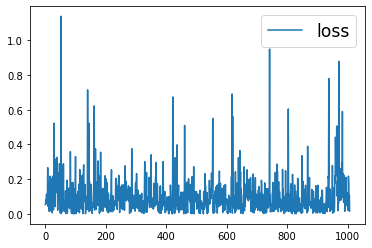

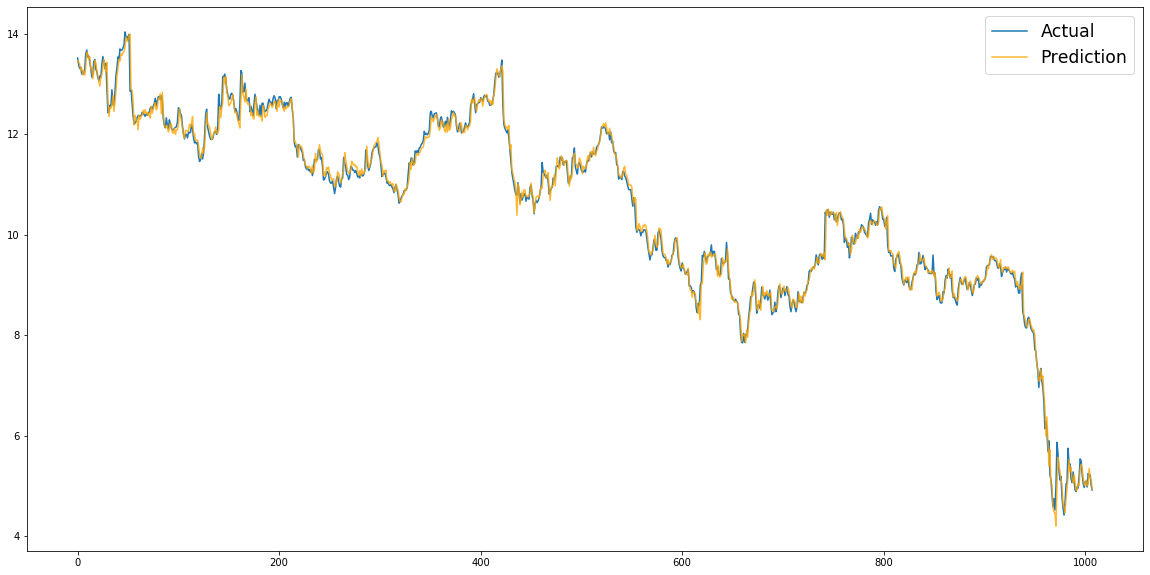

In [172]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

In [173]:
# Model 6: CNN 3

#train model:
predicted_high = []
actual_high = []
for trn in range(0,trn_size-300):
    X_train,X_test,y_train,y_test = build_data(trn,300)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00014: early stopping
1
Epoch 00016: early stopping
2
Epoch 00011: early stopping
3
Epoch 00016: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00015: early stopping
7
Epoch 00014: early stopping
8
Epoch 00011: early stopping
9
Epoch 00011: early stopping
10
Epoch 00015: early stopping
11
Epoch 00015: early stopping
12
Epoch 00011: early stopping
13
Epoch 00014: early stopping
14
Epoch 00012: early stopping
15
Epoch 00015: early stopping
16
Epoch 00011: early stopping
17
Epoch 00166: early stopping
18
Epoch 00011: early stopping
19
Epoch 00017: early stopping
20
Epoch 00042: early stopping
21
Epoch 00011: early stopping
22
Epoch 00011: early stopping
23
Epoch 00015: early stopping
24
Epoch 00017: early stopping
25
Epoch 00181: early stopping
26
Epoch 00032: early stopping
27
Epoch 00011: early stopping
28
Epoch 00096: early stopping
29
Epoch 00013: early stopping
30
Epoch 00168: early stopping
31
Epoch 00012: early stopping
32
Epoch 00011: ea

Epoch 00128: early stopping
261
Epoch 00016: early stopping
262
Epoch 00016: early stopping
263
Epoch 00020: early stopping
264
Epoch 00016: early stopping
265
Epoch 00011: early stopping
266
Epoch 00014: early stopping
267
Epoch 00061: early stopping
268
Epoch 00011: early stopping
269
Epoch 00064: early stopping
270
Epoch 00024: early stopping
271
Epoch 00012: early stopping
272
Epoch 00025: early stopping
273
Epoch 00014: early stopping
274
Epoch 00064: early stopping
275
Epoch 00024: early stopping
276
Epoch 00026: early stopping
277
Epoch 00013: early stopping
278
Epoch 00018: early stopping
279
Epoch 00016: early stopping
280
Epoch 00028: early stopping
281
Epoch 00046: early stopping
282
Epoch 00014: early stopping
283
Epoch 00012: early stopping
284
Epoch 00027: early stopping
285
Epoch 00022: early stopping
286
Epoch 00033: early stopping
287
Epoch 00024: early stopping
288
Epoch 00014: early stopping
289
Epoch 00015: early stopping
290
Epoch 00025: early stopping
291
Epoch 00

Epoch 00186: early stopping
518
Epoch 00374: early stopping
519
Epoch 00013: early stopping
520
Epoch 00040: early stopping
521
Epoch 00013: early stopping
522
Epoch 00011: early stopping
523
Epoch 00014: early stopping
524
Epoch 00011: early stopping
525
Epoch 00237: early stopping
526
Epoch 00011: early stopping
527
Epoch 00013: early stopping
528
Epoch 00015: early stopping
529
Epoch 00035: early stopping
530
Epoch 00011: early stopping
531
Epoch 00037: early stopping
532
Epoch 00011: early stopping
533
Epoch 00012: early stopping
534
Epoch 00035: early stopping
535
Epoch 00019: early stopping
536
Epoch 00041: early stopping
537
Epoch 00014: early stopping
538
Epoch 00042: early stopping
539
Epoch 00017: early stopping
540
Epoch 00013: early stopping
541
Epoch 00012: early stopping
542
Epoch 00019: early stopping
543
Epoch 00012: early stopping
544
Epoch 00013: early stopping
545
Epoch 00017: early stopping
546
Epoch 00011: early stopping
547
Epoch 00032: early stopping
548
Epoch 00

Epoch 00011: early stopping
776
Epoch 00015: early stopping
777
Epoch 00011: early stopping
778
Epoch 00012: early stopping
779
Epoch 00011: early stopping
780
Epoch 00013: early stopping
781
Epoch 00170: early stopping
782
Epoch 00081: early stopping
783
Epoch 00011: early stopping
784
Epoch 00011: early stopping
785
Epoch 00186: early stopping
786
Epoch 00011: early stopping
787
Epoch 00153: early stopping
788
Epoch 00011: early stopping
789
Epoch 00212: early stopping
790
Epoch 00011: early stopping
791
Epoch 00014: early stopping
792
Epoch 00012: early stopping
793
Epoch 00011: early stopping
794
Epoch 00011: early stopping
795
Epoch 00011: early stopping
796
Epoch 00011: early stopping
797
Epoch 00011: early stopping
798
Epoch 00011: early stopping
799
Epoch 00011: early stopping
800
Epoch 00015: early stopping
801
Epoch 00012: early stopping
802
Epoch 00011: early stopping
803
Epoch 00011: early stopping
804
Epoch 00014: early stopping
805
Epoch 00013: early stopping
806
Epoch 00

loss: 0.027654
loss: 0.02765422932803631
Mean Absolute Error= [[0.0929868]]
(958, 1, 1) (958,)


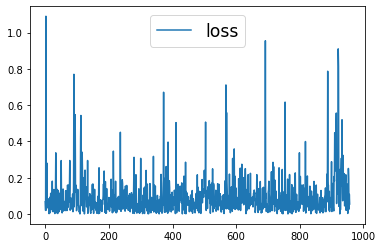

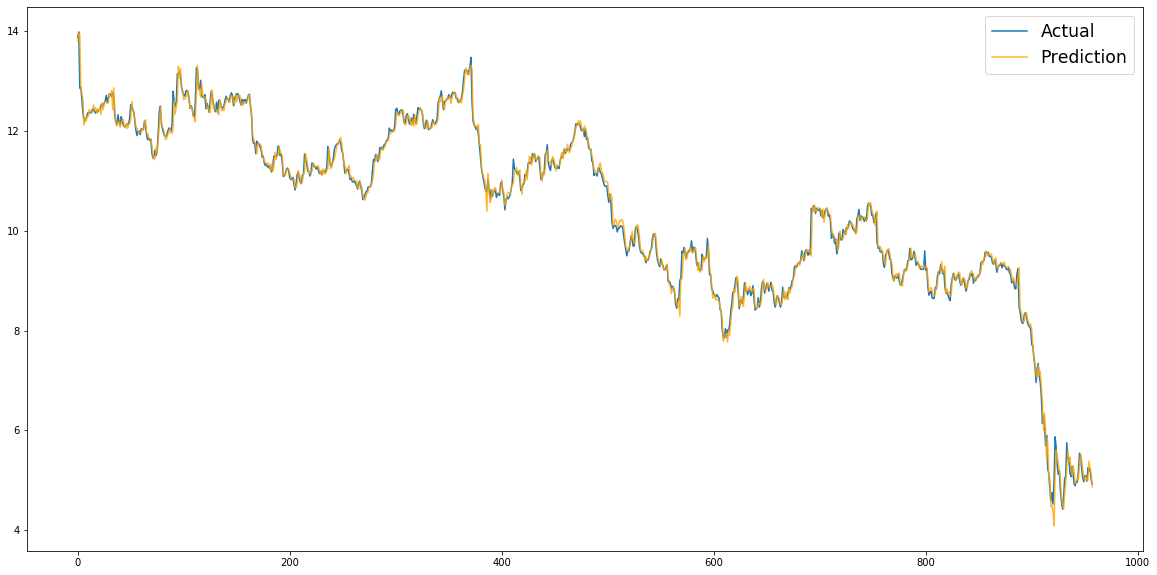

In [175]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 7: LSTM 1

In [176]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline

# define dataset
# reshape from [samples, timesteps] into [samples, timesteps, features]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(6, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [177]:
# demonstrate prediction
predicted_high = []
actual_high = []
for trn in range(0,trn_size-200):
    X_train,X_test,y_train,y_test = build_data(trn,200)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00049: early stopping
1
Epoch 00028: early stopping
2
Epoch 00011: early stopping
3
Epoch 00031: early stopping
4
Epoch 00014: early stopping
5
Epoch 00018: early stopping
6
Epoch 00020: early stopping
7
Epoch 00024: early stopping
8
Epoch 00012: early stopping
9
Epoch 00014: early stopping
10
Epoch 00049: early stopping
11
Epoch 00013: early stopping
12
Epoch 00011: early stopping
13
Epoch 00012: early stopping
14
Epoch 00012: early stopping
15
Epoch 00012: early stopping
16
Epoch 00017: early stopping
17
Epoch 00013: early stopping
18
Epoch 00012: early stopping
19
Epoch 00014: early stopping
20
Epoch 00014: early stopping
21
Epoch 00015: early stopping
22
Epoch 00018: early stopping
23
Epoch 00011: early stopping
24
Epoch 00015: early stopping
25
Epoch 00025: early stopping
26
Epoch 00012: early stopping
27
Epoch 00012: early stopping
28
Epoch 00011: early stopping
29
Epoch 00015: early stopping
30
Epoch 00013: early stopping
31
Epoch 00013: early stopping
32
Epoch 00011: ea

Epoch 00014: early stopping
261
Epoch 00013: early stopping
262
Epoch 00013: early stopping
263
Epoch 00013: early stopping
264
Epoch 00011: early stopping
265
Epoch 00011: early stopping
266
Epoch 00011: early stopping
267
Epoch 00011: early stopping
268
Epoch 00019: early stopping
269
Epoch 00011: early stopping
270
Epoch 00021: early stopping
271
Epoch 00028: early stopping
272
Epoch 00026: early stopping
273
Epoch 00012: early stopping
274
Epoch 00012: early stopping
275
Epoch 00011: early stopping
276
Epoch 00020: early stopping
277
Epoch 00011: early stopping
278
Epoch 00044: early stopping
279
Epoch 00025: early stopping
280
Epoch 00055: early stopping
281
Epoch 00014: early stopping
282
Epoch 00011: early stopping
283
Epoch 00011: early stopping
284
Epoch 00011: early stopping
285
Epoch 00109: early stopping
286
Epoch 00011: early stopping
287
Epoch 00011: early stopping
288
Epoch 00011: early stopping
289
Epoch 00011: early stopping
290
Epoch 00011: early stopping
291
Epoch 00

Epoch 00013: early stopping
518
Epoch 00013: early stopping
519
Epoch 00014: early stopping
520
Epoch 00012: early stopping
521
Epoch 00011: early stopping
522
Epoch 00011: early stopping
523
Epoch 00011: early stopping
524
Epoch 00011: early stopping
525
Epoch 00011: early stopping
526
Epoch 00012: early stopping
527
Epoch 00011: early stopping
528
Epoch 00011: early stopping
529
Epoch 00011: early stopping
530
Epoch 00011: early stopping
531
Epoch 00011: early stopping
532
Epoch 00033: early stopping
533
Epoch 00011: early stopping
534
Epoch 00011: early stopping
535
Epoch 00011: early stopping
536
Epoch 00011: early stopping
537
Epoch 00042: early stopping
538
Epoch 00013: early stopping
539
Epoch 00013: early stopping
540
Epoch 00017: early stopping
541
Epoch 00012: early stopping
542
Epoch 00190: early stopping
543
Epoch 00011: early stopping
544
Epoch 00013: early stopping
545
Epoch 00055: early stopping
546
Epoch 00011: early stopping
547
Epoch 00011: early stopping
548
Epoch 00

Epoch 00011: early stopping
775
Epoch 00011: early stopping
776
Epoch 00011: early stopping
777
Epoch 00011: early stopping
778
Epoch 00036: early stopping
779
Epoch 00011: early stopping
780
Epoch 00019: early stopping
781
Epoch 00014: early stopping
782
Epoch 00027: early stopping
783
Epoch 00014: early stopping
784
Epoch 00016: early stopping
785
Epoch 00011: early stopping
786
Epoch 00015: early stopping
787
Epoch 00026: early stopping
788
Epoch 00014: early stopping
789
Epoch 00017: early stopping
790
Epoch 00018: early stopping
791
Epoch 00011: early stopping
792
Epoch 00011: early stopping
793
Epoch 00015: early stopping
794
Epoch 00020: early stopping
795
Epoch 00011: early stopping
796
Epoch 00029: early stopping
797
Epoch 00022: early stopping
798
Epoch 00014: early stopping
799
Epoch 00030: early stopping
800
Epoch 00013: early stopping
801
Epoch 00014: early stopping
802
Epoch 00013: early stopping
803
Epoch 00013: early stopping
804
Epoch 00013: early stopping
805
Epoch 00

Epoch 00033: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00011: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00033: early stopping
1040
Epoch 00040: early stopping
1041
Epoch 00011: early stopping
1042
Epoch 00038: early stopping
1043
Epoch 00012: early stopping
1044
Epoch 00014: early stopping
1045
Epoch 00100: early stopping
1046
Epoch 00011: early stopping
1047
Epoch 00037: early stopping
1048
Epoch 00011: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00012: early stopping
1051
Epoch 00014: early stopping
1052
Epoch 00014: early stopping
1053
Epoch 00014: early stopping
1054
Epoch 00011: early stopping
1055
Epoch 00061: early stopping
1056
Epoch 00016: early stopping
1057
Epoch 00011: early stopping


loss: 3.833597
loss: 3.8335967859625817
Mean Absolute Error= [[2764.6675]]
(1058, 1, 1) (1058,)


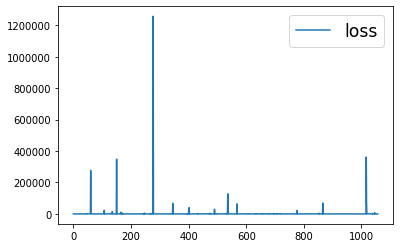

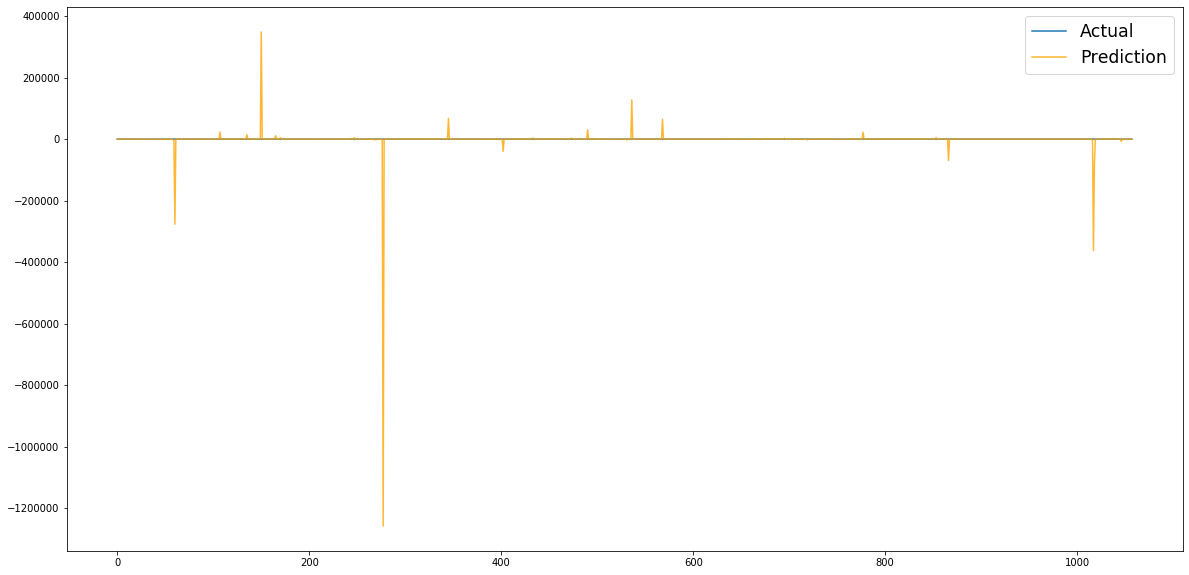

In [182]:
print('loss:', '%f'%history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 8 : LSTM 2

In [183]:
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

In [184]:
# demonstrate prediction
predicted_high = []
actual_high = []
for trn in range(0,trn_size-200):
    X_train,X_test,y_train,y_test = build_data(trn,200)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00052: early stopping
1
Epoch 00015: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00491: early stopping
9
Epoch 00011: early stopping
10
Epoch 00011: early stopping
11
Epoch 00015: early stopping
12
Epoch 00025: early stopping
13
Epoch 00022: early stopping
14
Epoch 00019: early stopping
15
Epoch 00012: early stopping
16
Epoch 00012: early stopping
17
Epoch 00037: early stopping
18
Epoch 00013: early stopping
19
Epoch 00024: early stopping
20
Epoch 00015: early stopping
21
Epoch 00017: early stopping
22
Epoch 00021: early stopping
23
Epoch 00011: early stopping
24
Epoch 00031: early stopping
25
Epoch 00012: early stopping
26
Epoch 00011: early stopping
27
Epoch 00017: early stopping
28
Epoch 00011: early stopping
29
Epoch 00025: early stopping
30
Epoch 00032: early stopping
31
Epoch 00012: early stopping
32
Epoch 00028: ea

Epoch 00016: early stopping
261
Epoch 00011: early stopping
262
Epoch 00015: early stopping
263
Epoch 00020: early stopping
264
Epoch 00048: early stopping
265
Epoch 00015: early stopping
266
Epoch 00025: early stopping
267
Epoch 00020: early stopping
268
Epoch 00019: early stopping
269
Epoch 00011: early stopping
270
Epoch 00013: early stopping
271
Epoch 00014: early stopping
272
Epoch 00018: early stopping
273
Epoch 00283: early stopping
274
Epoch 00014: early stopping
275
Epoch 00059: early stopping
276
Epoch 00098: early stopping
277
Epoch 00396: early stopping
278
Epoch 00052: early stopping
279
Epoch 00583: early stopping
280
Epoch 00014: early stopping
281
Epoch 00015: early stopping
282
Epoch 00011: early stopping
283
Epoch 00022: early stopping
284
Epoch 00017: early stopping
285
Epoch 00017: early stopping
286
Epoch 00029: early stopping
287
Epoch 00013: early stopping
288
Epoch 00015: early stopping
289
Epoch 00012: early stopping
290
Epoch 00013: early stopping
291
Epoch 00

Epoch 00012: early stopping
518
Epoch 00013: early stopping
519
Epoch 00012: early stopping
520
Epoch 00025: early stopping
521
Epoch 00015: early stopping
522
Epoch 00016: early stopping
523
Epoch 00015: early stopping
524
Epoch 00018: early stopping
525
Epoch 00030: early stopping
526
Epoch 00016: early stopping
527
Epoch 00023: early stopping
528
Epoch 00029: early stopping
529
Epoch 00017: early stopping
530
Epoch 00012: early stopping
531
Epoch 00015: early stopping
532
Epoch 00023: early stopping
533
Epoch 00012: early stopping
534
Epoch 00012: early stopping
535
Epoch 00017: early stopping
536
Epoch 00012: early stopping
537
Epoch 00011: early stopping
538
Epoch 00029: early stopping
539
Epoch 00017: early stopping
540
Epoch 00057: early stopping
541
Epoch 00029: early stopping
542
Epoch 00029: early stopping
543
Epoch 00033: early stopping
544
Epoch 00012: early stopping
545
Epoch 00024: early stopping
546
Epoch 00020: early stopping
547
Epoch 00020: early stopping
548
Epoch 00

Epoch 00028: early stopping
775
Epoch 00011: early stopping
776
Epoch 00011: early stopping
777
Epoch 00017: early stopping
778
Epoch 00026: early stopping
779
Epoch 00016: early stopping
780
Epoch 00042: early stopping
781
Epoch 00024: early stopping
782
Epoch 00017: early stopping
783
Epoch 00012: early stopping
784
Epoch 00026: early stopping
785
Epoch 00038: early stopping
786
Epoch 00013: early stopping
787
Epoch 00013: early stopping
788
Epoch 00028: early stopping
789
Epoch 00013: early stopping
790
Epoch 00011: early stopping
791
Epoch 00011: early stopping
792
Epoch 00023: early stopping
793
Epoch 00011: early stopping
794
Epoch 00019: early stopping
795
Epoch 00053: early stopping
796
Epoch 00012: early stopping
797
Epoch 00012: early stopping
798
Epoch 00016: early stopping
799
Epoch 00011: early stopping
800
Epoch 00017: early stopping
801
Epoch 00011: early stopping
802
Epoch 00024: early stopping
803
Epoch 00012: early stopping
804
Epoch 00011: early stopping
805
Epoch 00

Epoch 00014: early stopping
1031
Epoch 00015: early stopping
1032
Epoch 00019: early stopping
1033
Epoch 00014: early stopping
1034
Epoch 00021: early stopping
1035
Epoch 00011: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00014: early stopping
1038
Epoch 00013: early stopping
1039
Epoch 00018: early stopping
1040
Epoch 00012: early stopping
1041
Epoch 00012: early stopping
1042
Epoch 00015: early stopping
1043
Epoch 00018: early stopping
1044
Epoch 00015: early stopping
1045
Epoch 00012: early stopping
1046
Epoch 00012: early stopping
1047
Epoch 00011: early stopping
1048
Epoch 00054: early stopping
1049
Epoch 00037: early stopping
1050
Epoch 00011: early stopping
1051
Epoch 00027: early stopping
1052
Epoch 00031: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00011: early stopping
1055
Epoch 00018: early stopping
1056
Epoch 00038: early stopping
1057
Epoch 00021: early stopping


loss: 0.019310
loss: 0.019310064762830734
Mean Absolute Error= [[0.11428322]]
(1058, 1, 1) (1058,)


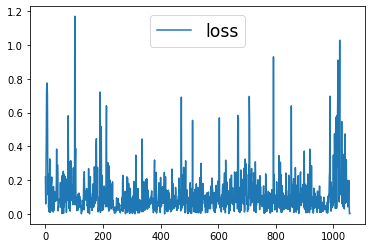

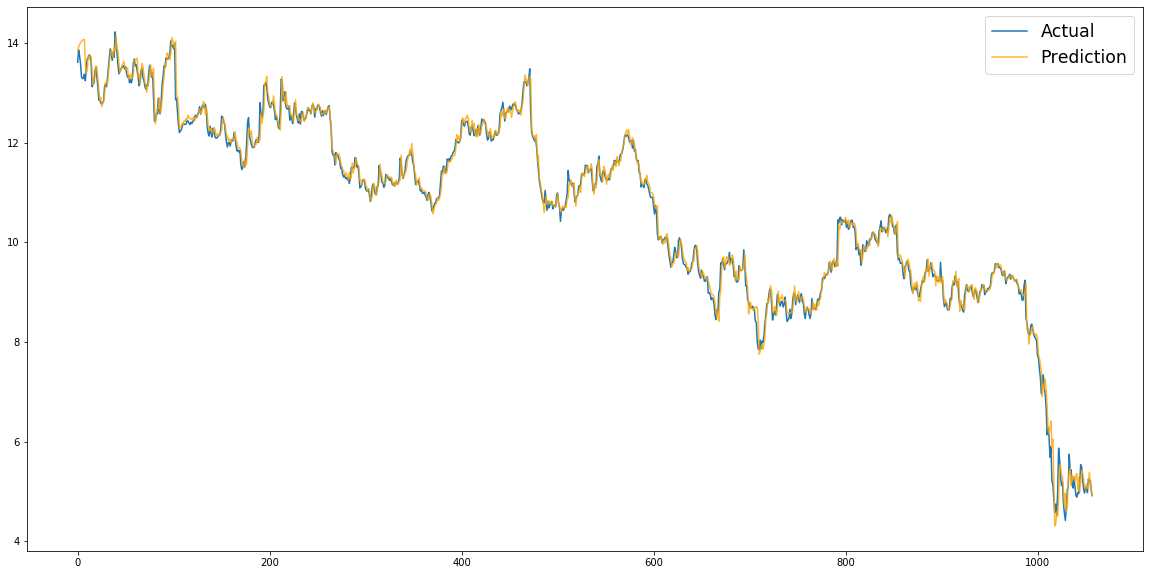

In [185]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 9: LSTM 2

In [187]:
# demonstrate prediction
predicted_high = []
actual_high = []
for trn in range(0,trn_size-250):
    X_train,X_test,y_train,y_test = build_data(trn,250)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00021: early stopping
1
Epoch 00011: early stopping
2
Epoch 00012: early stopping
3
Epoch 00011: early stopping
4
Epoch 00011: early stopping
5
Epoch 00041: early stopping
6
Epoch 00011: early stopping
7
Epoch 00031: early stopping
8
Epoch 00013: early stopping
9
Epoch 00013: early stopping
10
Epoch 00017: early stopping
11
Epoch 00012: early stopping
12
Epoch 00018: early stopping
13
Epoch 00027: early stopping
14
Epoch 00012: early stopping
15
Epoch 00015: early stopping
16
Epoch 00022: early stopping
17
Epoch 00044: early stopping
18
Epoch 00043: early stopping
19
Epoch 00013: early stopping
20
Epoch 00023: early stopping
21
Epoch 00023: early stopping
22
Epoch 00011: early stopping
23
Epoch 00015: early stopping
24
Epoch 00034: early stopping
25
Epoch 00013: early stopping
26
Epoch 00018: early stopping
27
Epoch 00018: early stopping
28
Epoch 00023: early stopping
29
Epoch 00018: early stopping
30
Epoch 00013: early stopping
31
Epoch 00015: early stopping
32
Epoch 00013: ea

Epoch 00015: early stopping
261
Epoch 00015: early stopping
262
Epoch 00011: early stopping
263
Epoch 00016: early stopping
264
Epoch 00020: early stopping
265
Epoch 00011: early stopping
266
Epoch 00021: early stopping
267
Epoch 00034: early stopping
268
Epoch 00015: early stopping
269
Epoch 00019: early stopping
270
Epoch 00019: early stopping
271
Epoch 00026: early stopping
272
Epoch 00012: early stopping
273
Epoch 00033: early stopping
274
Epoch 00013: early stopping
275
Epoch 00039: early stopping
276
Epoch 00018: early stopping
277
Epoch 00025: early stopping
278
Epoch 00019: early stopping
279
Epoch 00023: early stopping
280
Epoch 00011: early stopping
281
Epoch 00017: early stopping
282
Epoch 00021: early stopping
283
Epoch 00027: early stopping
284
Epoch 00011: early stopping
285
Epoch 00018: early stopping
286
Epoch 00029: early stopping
287
Epoch 00034: early stopping
288
Epoch 00012: early stopping
289
Epoch 00011: early stopping
290
Epoch 00013: early stopping
291
Epoch 00

Epoch 00020: early stopping
518
Epoch 00024: early stopping
519
Epoch 00029: early stopping
520
Epoch 00016: early stopping
521
Epoch 00024: early stopping
522
Epoch 00019: early stopping
523
Epoch 00011: early stopping
524
Epoch 00018: early stopping
525
Epoch 00012: early stopping
526
Epoch 00033: early stopping
527
Epoch 00013: early stopping
528
Epoch 00012: early stopping
529
Epoch 00018: early stopping
530
Epoch 00017: early stopping
531
Epoch 00011: early stopping
532
Epoch 00036: early stopping
533
Epoch 00013: early stopping
534
Epoch 00019: early stopping
535
Epoch 00013: early stopping
536
Epoch 00014: early stopping
537
Epoch 00034: early stopping
538
Epoch 00014: early stopping
539
Epoch 00012: early stopping
540
Epoch 00013: early stopping
541
Epoch 00013: early stopping
542
Epoch 00023: early stopping
543
Epoch 00012: early stopping
544
Epoch 00012: early stopping
545
Epoch 00020: early stopping
546
Epoch 00023: early stopping
547
Epoch 00028: early stopping
548
Epoch 00

Epoch 00020: early stopping
775
Epoch 00011: early stopping
776
Epoch 00036: early stopping
777
Epoch 00013: early stopping
778
Epoch 00025: early stopping
779
Epoch 00013: early stopping
780
Epoch 00012: early stopping
781
Epoch 00032: early stopping
782
Epoch 00013: early stopping
783
Epoch 00018: early stopping
784
Epoch 00030: early stopping
785
Epoch 00016: early stopping
786
Epoch 00020: early stopping
787
Epoch 00015: early stopping
788
Epoch 00011: early stopping
789
Epoch 00024: early stopping
790
Epoch 00024: early stopping
791
Epoch 00022: early stopping
792
Epoch 00019: early stopping
793
Epoch 00018: early stopping
794
Epoch 00020: early stopping
795
Epoch 00037: early stopping
796
Epoch 00047: early stopping
797
Epoch 00013: early stopping
798
Epoch 00041: early stopping
799
Epoch 00011: early stopping
800
Epoch 00029: early stopping
801
Epoch 00028: early stopping
802
Epoch 00011: early stopping
803
Epoch 00016: early stopping
804
Epoch 00024: early stopping
805
Epoch 00

loss: 0.015175
loss: 0.015175431072711944
Mean Absolute Error= [[0.11942305]]
(1008, 1, 1) (1008,)


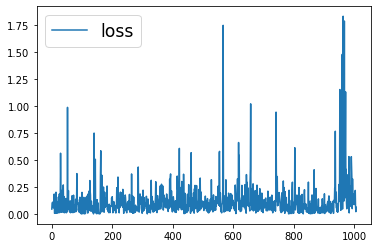

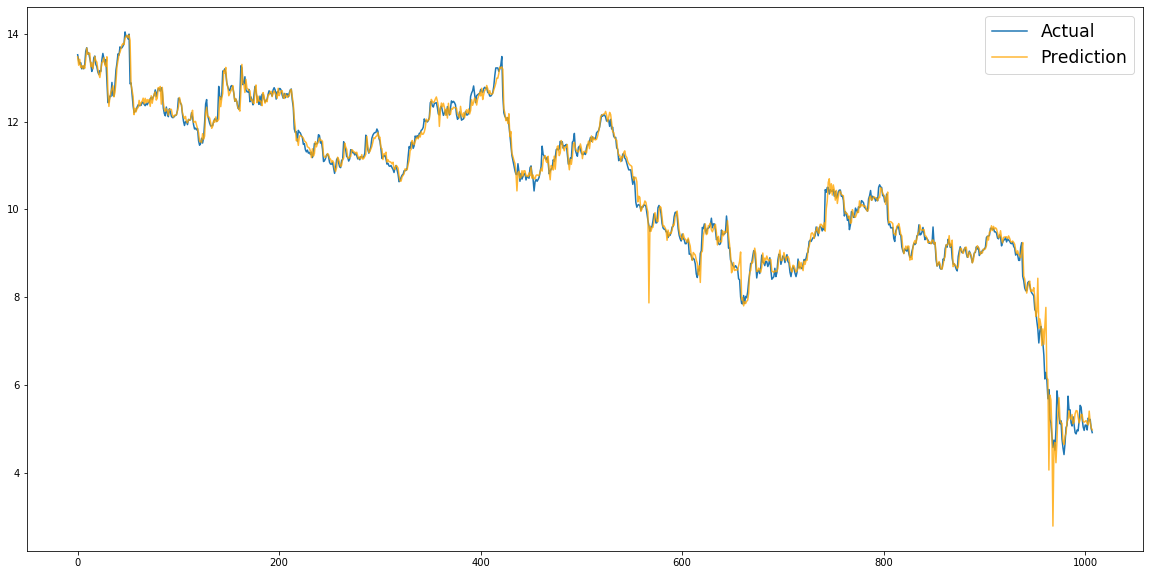

In [188]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 10 : LSTM 3

In [189]:
# demonstrate prediction
predicted_high = []
actual_high = []
for trn in range(0,trn_size-150):
    X_train,X_test,y_train,y_test = build_data(trn,150)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00011: early stopping
1
Epoch 00013: early stopping
2
Epoch 00011: early stopping
3
Epoch 00013: early stopping
4
Epoch 00012: early stopping
5
Epoch 00079: early stopping
6
Epoch 00397: early stopping
7
Epoch 00018: early stopping
8
Epoch 00011: early stopping
9
Epoch 00087: early stopping
10
Epoch 00013: early stopping
11
Epoch 00011: early stopping
12
Epoch 00011: early stopping
13
Epoch 00012: early stopping
14
Epoch 00027: early stopping
15
Epoch 00011: early stopping
16
Epoch 00087: early stopping
17
Epoch 00011: early stopping
18
Epoch 00011: early stopping
19
Epoch 00011: early stopping
20
Epoch 00013: early stopping
21
Epoch 00017: early stopping
22
Epoch 00014: early stopping
23
Epoch 00012: early stopping
24
Epoch 00012: early stopping
25
Epoch 00011: early stopping
26
Epoch 00015: early stopping
27
Epoch 00040: early stopping
28
Epoch 00031: early stopping
29
Epoch 00017: early stopping
30
Epoch 00014: early stopping
31
Epoch 00073: early stopping
32
Epoch 00011: ea

Epoch 00028: early stopping
261
Epoch 00012: early stopping
262
Epoch 00035: early stopping
263
Epoch 00011: early stopping
264
Epoch 00074: early stopping
265
Epoch 00037: early stopping
266
Epoch 00011: early stopping
267
Epoch 00011: early stopping
268
Epoch 00100: early stopping
269
Epoch 00081: early stopping
270
Epoch 00040: early stopping
271
Epoch 00014: early stopping
272
Epoch 00020: early stopping
273
Epoch 00023: early stopping
274
Epoch 00016: early stopping
275
Epoch 00019: early stopping
276
Epoch 00017: early stopping
277
Epoch 00023: early stopping
278
Epoch 00012: early stopping
279
Epoch 00012: early stopping
280
Epoch 00036: early stopping
281
Epoch 00016: early stopping
282
Epoch 00013: early stopping
283
Epoch 00031: early stopping
284
Epoch 00029: early stopping
285
Epoch 00027: early stopping
286
Epoch 00018: early stopping
287
Epoch 00020: early stopping
288
Epoch 00019: early stopping
289
Epoch 00040: early stopping
290
Epoch 00034: early stopping
291
Epoch 00

Epoch 00012: early stopping
518
Epoch 00013: early stopping
519
Epoch 00012: early stopping
520
Epoch 00014: early stopping
521
Epoch 00014: early stopping
522
Epoch 00015: early stopping
523
Epoch 00017: early stopping
524
Epoch 00032: early stopping
525
Epoch 00021: early stopping
526
Epoch 00019: early stopping
527
Epoch 00011: early stopping
528
Epoch 00150: early stopping
529
Epoch 00012: early stopping
530
Epoch 00011: early stopping
531
Epoch 00012: early stopping
532
Epoch 00039: early stopping
533
Epoch 00014: early stopping
534
Epoch 00033: early stopping
535
Epoch 00018: early stopping
536
Epoch 00036: early stopping
537
Epoch 00038: early stopping
538
Epoch 00024: early stopping
539
Epoch 00017: early stopping
540
Epoch 00011: early stopping
541
Epoch 00011: early stopping
542
Epoch 00017: early stopping
543
Epoch 00020: early stopping
544
Epoch 00034: early stopping
545
Epoch 00019: early stopping
546
Epoch 00016: early stopping
547
Epoch 00022: early stopping
548
Epoch 00

Epoch 00034: early stopping
775
Epoch 00016: early stopping
776
Epoch 00012: early stopping
777
Epoch 00019: early stopping
778
Epoch 00011: early stopping
779
Epoch 00013: early stopping
780
Epoch 00016: early stopping
781
Epoch 00028: early stopping
782
Epoch 00012: early stopping
783
Epoch 00080: early stopping
784
Epoch 00070: early stopping
785
Epoch 00076: early stopping
786
Epoch 00029: early stopping
787
Epoch 00011: early stopping
788
Epoch 00117: early stopping
789
Epoch 00013: early stopping
790
Epoch 00015: early stopping
791
Epoch 00032: early stopping
792
Epoch 00011: early stopping
793
Epoch 00063: early stopping
794
Epoch 00015: early stopping
795
Epoch 00012: early stopping
796
Epoch 00029: early stopping
797
Epoch 00012: early stopping
798
Epoch 00038: early stopping
799
Epoch 00018: early stopping
800
Epoch 00038: early stopping
801
Epoch 00012: early stopping
802
Epoch 00423: early stopping
803
Epoch 00017: early stopping
804
Epoch 00016: early stopping
805
Epoch 00

Epoch 00013: early stopping
1031
Epoch 00013: early stopping
1032
Epoch 00017: early stopping
1033
Epoch 00017: early stopping
1034
Epoch 00013: early stopping
1035
Epoch 00016: early stopping
1036
Epoch 00020: early stopping
1037
Epoch 00013: early stopping
1038
Epoch 00014: early stopping
1039
Epoch 00015: early stopping
1040
Epoch 00019: early stopping
1041
Epoch 00031: early stopping
1042
Epoch 00040: early stopping
1043
Epoch 00014: early stopping
1044
Epoch 00022: early stopping
1045
Epoch 00014: early stopping
1046
Epoch 00046: early stopping
1047
Epoch 00018: early stopping
1048
Epoch 00064: early stopping
1049
Epoch 00014: early stopping
1050
Epoch 00058: early stopping
1051
Epoch 00059: early stopping
1052
Epoch 00011: early stopping
1053
Epoch 00013: early stopping
1054
Epoch 00015: early stopping
1055
Epoch 00094: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00022: early stopping
1058
Epoch 00059: early stopping
1059
Epoch 00011: early stopping
1060
Epoch 0005

loss: 0.014205
loss: 0.014204837282498677
Mean Absolute Error= [[0.13260545]]
(1108, 1, 1) (1108,)


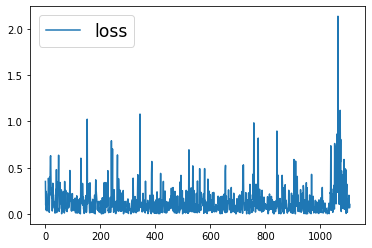

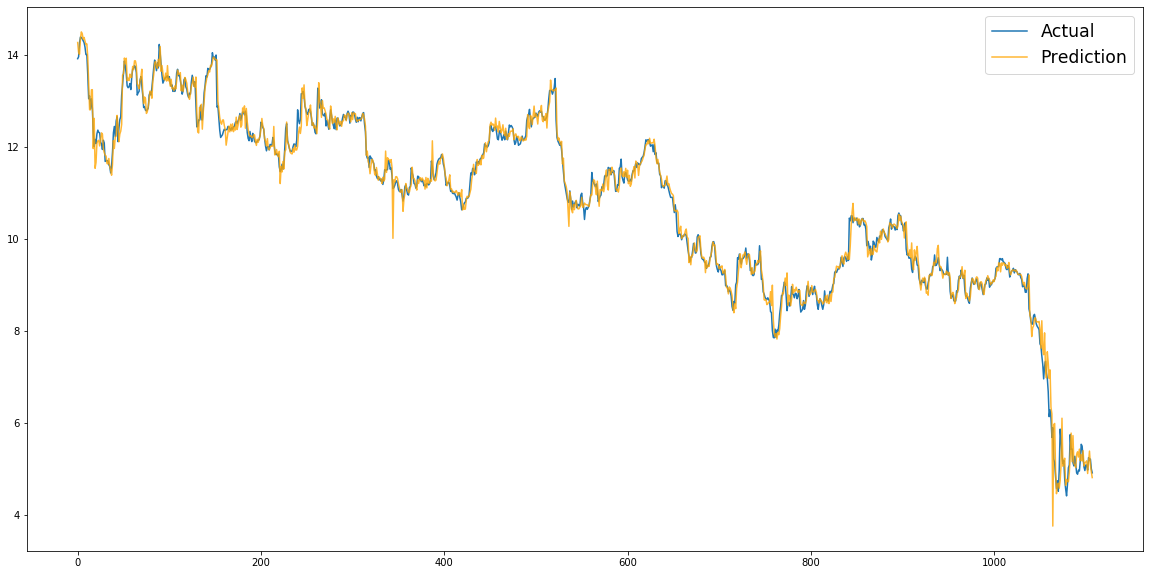

In [190]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 11: LSTM 4

In [191]:
# demonstrate prediction
predicted_high = []
actual_high = []
for trn in range(0,trn_size-300):
    X_train,X_test,y_train,y_test = build_data(trn,300)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0
Epoch 00014: early stopping
1
Epoch 00015: early stopping
2
Epoch 00040: early stopping
3
Epoch 00011: early stopping
4
Epoch 00047: early stopping
5
Epoch 00014: early stopping
6
Epoch 00076: early stopping
7
Epoch 00020: early stopping
8
Epoch 00016: early stopping
9
Epoch 00016: early stopping
10
Epoch 00017: early stopping
11
Epoch 00014: early stopping
12
Epoch 00022: early stopping
13
Epoch 00025: early stopping
14
Epoch 00016: early stopping
15
Epoch 00054: early stopping
16
Epoch 00011: early stopping
17
Epoch 00019: early stopping
18
Epoch 00017: early stopping
19
Epoch 00013: early stopping
20
Epoch 00016: early stopping
21
Epoch 00020: early stopping
22
Epoch 00018: early stopping
23
Epoch 00015: early stopping
24
Epoch 00015: early stopping
25
Epoch 00028: early stopping
26
Epoch 00022: early stopping
27
Epoch 00011: early stopping
28
Epoch 00012: early stopping
29
Epoch 00015: early stopping
30
Epoch 00027: early stopping
31
Epoch 00030: early stopping
32
Epoch 00026: ea

Epoch 00013: early stopping
261
Epoch 00020: early stopping
262
Epoch 00015: early stopping
263
Epoch 00011: early stopping
264
Epoch 00017: early stopping
265
Epoch 00030: early stopping
266
Epoch 00030: early stopping
267
Epoch 00013: early stopping
268
Epoch 00021: early stopping
269
Epoch 00020: early stopping
270
Epoch 00019: early stopping
271
Epoch 00014: early stopping
272
Epoch 00013: early stopping
273
Epoch 00012: early stopping
274
Epoch 00012: early stopping
275
Epoch 00013: early stopping
276
Epoch 00011: early stopping
277
Epoch 00020: early stopping
278
Epoch 00044: early stopping
279
Epoch 00023: early stopping
280
Epoch 00040: early stopping
281
Epoch 00030: early stopping
282
Epoch 00024: early stopping
283
Epoch 00017: early stopping
284
Epoch 00012: early stopping
285
Epoch 00016: early stopping
286
Epoch 00011: early stopping
287
Epoch 00024: early stopping
288
Epoch 00025: early stopping
289
Epoch 00014: early stopping
290
Epoch 00017: early stopping
291
Epoch 00

Epoch 00016: early stopping
518
Epoch 00014: early stopping
519
Epoch 00026: early stopping
520
Epoch 00018: early stopping
521
Epoch 00029: early stopping
522
Epoch 00041: early stopping
523
Epoch 00013: early stopping
524
Epoch 00022: early stopping
525
Epoch 00013: early stopping
526
Epoch 00030: early stopping
527
Epoch 00021: early stopping
528
Epoch 00012: early stopping
529
Epoch 00013: early stopping
530
Epoch 00016: early stopping
531
Epoch 00026: early stopping
532
Epoch 00013: early stopping
533
Epoch 00012: early stopping
534
Epoch 00022: early stopping
535
Epoch 00018: early stopping
536
Epoch 00017: early stopping
537
Epoch 00024: early stopping
538
Epoch 00024: early stopping
539
Epoch 00025: early stopping
540
Epoch 00019: early stopping
541
Epoch 00013: early stopping
542
Epoch 00011: early stopping
543
Epoch 00018: early stopping
544
Epoch 00027: early stopping
545
Epoch 00013: early stopping
546
Epoch 00029: early stopping
547
Epoch 00028: early stopping
548
Epoch 00

Epoch 00020: early stopping
775
Epoch 00015: early stopping
776
Epoch 00019: early stopping
777
Epoch 00013: early stopping
778
Epoch 00011: early stopping
779
Epoch 00024: early stopping
780
Epoch 00027: early stopping
781
Epoch 00022: early stopping
782
Epoch 00031: early stopping
783
Epoch 00014: early stopping
784
Epoch 00025: early stopping
785
Epoch 00015: early stopping
786
Epoch 00025: early stopping
787
Epoch 00016: early stopping
788
Epoch 00043: early stopping
789
Epoch 00022: early stopping
790
Epoch 00018: early stopping
791
Epoch 00024: early stopping
792
Epoch 00014: early stopping
793
Epoch 00012: early stopping
794
Epoch 00011: early stopping
795
Epoch 00012: early stopping
796
Epoch 00017: early stopping
797
Epoch 00012: early stopping
798
Epoch 00024: early stopping
799
Epoch 00014: early stopping
800
Epoch 00021: early stopping
801
Epoch 00027: early stopping
802
Epoch 00011: early stopping
803
Epoch 00013: early stopping
804
Epoch 00015: early stopping
805
Epoch 00

loss: 0.015255
loss: 0.015255031709869703
Mean Absolute Error= [[0.11635224]]
(958, 1, 1) (958,)


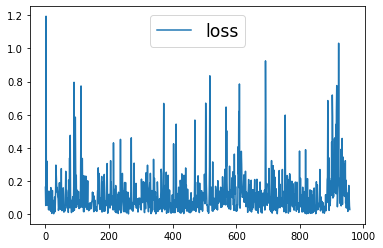

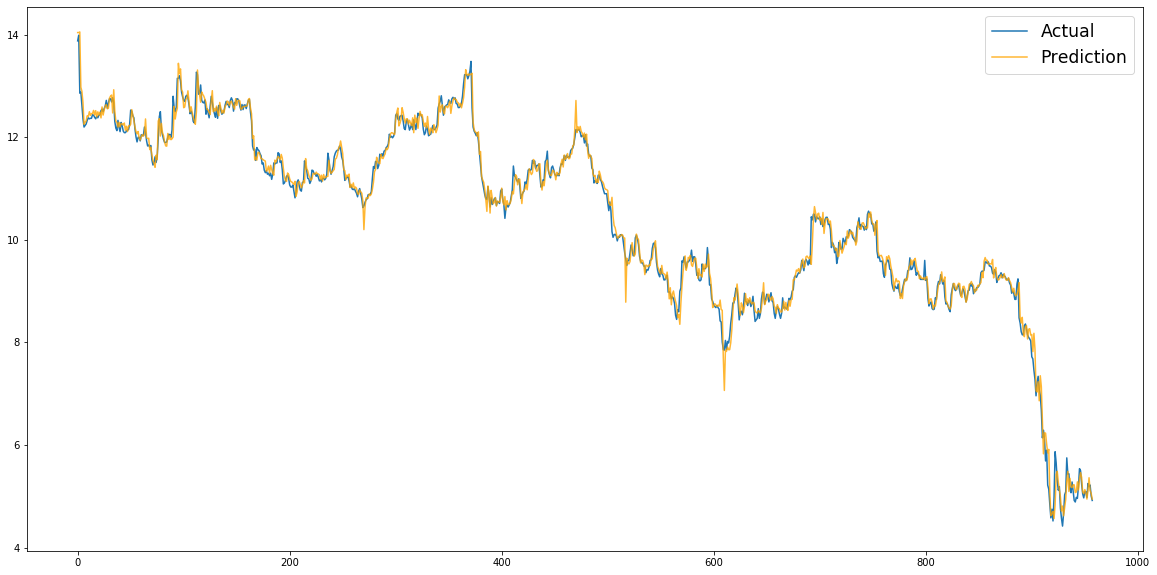

In [193]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)

# Model 12: Variable selection:

In [212]:
#convert data:
#print(df.loc[['2015-05-15']])

df1 = df[['High']]
Xarr = df1.rename_axis('ID').values
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])

yarr = np.delete(yarr, 0)
print('xarr:',Xarr[0:5],'yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

print(np.array(X_train).shape)
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

Xarr: [[15.49]
 [15.64]
 [15.63]
 [15.56]
 [15.55]]
yarr: [[15.49]
 [15.64]
 [15.63]
 [15.56]
 [15.55]]
xarr: [[15.49]
 [15.64]
 [15.63]
 [15.56]
 [15.55]] yarr: [15.64 15.63 15.56 15.55 15.5 ]
X shape: (1259, 1)
y shape: (1258,)
(150, 1)


In [213]:
# demonstrate prediction
predicted_high = []
actual_high = []
for trn in range(0,trn_size-150):
    X_train,X_test,y_train,y_test = build_data(trn,150)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=1000,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    predicted_high.append(yhat)
    actual_high.append(y_test[0])

0


ValueError: Error when checking input: expected lstm_15_input to have 3 dimensions, but got array with shape (150, 1)

In [ ]:
print('loss:', '%f'%history.history['loss'][-1])
print('loss:', history.history['loss'][-1])
print('Mean Absolute Error=', mae(predicted_high,actual_high))    
evaluate_model(np.array(predicted_high), np.array(actual_high))
print(np.array(predicted_high).shape, np.array(actual_high).shape)